In [ ]:
import os
import random
from collections import defaultdict

def print_folder_structure(base_path, indent=0):
    try:
        items = os.listdir(base_path)
    except PermissionError:
        print(" " * indent + f"[ACCESS DENIED] {base_path}")
        return

    # Separate folders and files
    folders = [f for f in items if os.path.isdir(os.path.join(base_path, f))]
    files = [f for f in items if os.path.isfile(os.path.join(base_path, f))]

    # Print current folder name
    print(" " * indent + f"📁 {os.path.basename(base_path) or base_path}")

    # Summarize files by extension
    if files:
        files_by_ext = defaultdict(list)
        for file in files:
            ext = os.path.splitext(file)[1].lower() or "[no extension]"
            files_by_ext[ext].append(file)

        for ext, file_list in files_by_ext.items():
            total_files = len(file_list)
            print(" " * (indent + 2) + f"📄 Extension: {ext}  (Total: {total_files})")

    # Recurse through subfolders
    for folder in folders:
        print_folder_structure(os.path.join(base_path, folder), indent + 2)

if __name__ == "__main__":
    base_directory = "/content/drive/MyDrive/Glaucoma detection"

    if not os.path.exists(base_directory):
        print(f"Path does not exist: {base_directory}")
    else:
        print_folder_structure(base_directory)


📁 Glaucoma detection
  📄 Extension: .csv  (Total: 6)
  📄 Extension: .pth  (Total: 3)
  📁 blood-vessel
    📁 blood-vessel
      📄 Extension: .png  (Total: 462)
  📁 full-fundus
    📁 full-fundus
      📄 Extension: .png  (Total: 12449)
  📁 optic-cup
    📁 optic-cup
      📄 Extension: .png  (Total: 2874)
  📁 optic-disc
    📁 optic-disc
      📄 Extension: .png  (Total: 3103)
  📁 spectral-oct-cup
    📁 spectral-oct-cup
      📄 Extension: .png  (Total: 45)
  📁 spectral-oct
    📁 spectral-oct
      📄 Extension: .png  (Total: 79)
  📁 vessel-vein
    📁 vessel-vein
      📄 Extension: .png  (Total: 22)
  📁 spectral-oct-disc
    📁 spectral-oct-disc
      📄 Extension: .png  (Total: 45)
  📁 vessel-artery
    📁 vessel-artery
      📄 Extension: .png  (Total: 22)
  📁 checkpoints
    📄 Extension: .pth  (Total: 5)
  📁 Conv_checkpoints
    📄 Extension: .pth  (Total: 5)
  📁 figures
    📄 Extension: .png  (Total: 8)
  📁 ViT_checkpoints
    📄 Extension: .pth  (Total: 1)
  📁 checkpoints_vit_b16
    📄 Extension

In [ ]:
import pandas as pd
import os
import numpy as np
import warnings

def show_csv_sample(csv_path, n=100):
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}")
        return

    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        print(f"✅ Loaded file: {csv_path}")
        print(f"🧾 Total rows: {len(df)}, Columns: {len(df.columns)}")

        print("\n📋 Columns:")
        print(", ".join(df.columns))

        print("\n🎲 Random Sample (up to 100 rows):\n")
        sample_df = df.sample(n=min(n, len(df)), random_state=None)
        print(sample_df.to_string(index=False))

if __name__ == "__main__":
    csv_path = "/content/drive/MyDrive/Glaucoma detection/metadata - standardized.csv"
    show_csv_sample(csv_path)


✅ Loaded file: /content/drive/MyDrive/Glaucoma detection/metadata - standardized.csv
🧾 Total rows: 12449, Columns: 48

📋 Columns:
names, types, type_expanded, isColor, original_name, patient_id, fundus, fundus_od_seg, fundus_oc_seg, bv_seg, artery_seg, vein_seg, oct, oct_oc_seg, oct_od_seg, sex, gender, age, eye, sbp, dbp, hr, iop, vcdr, Unnamed: 24, notchI_present, notchS_present, notchN_present, notchT_present, expert1_grade, expert2_grade, expert3_grade, expert4_grade, expert5_grade, cdr_avg, cdr_expert1, cdr_expert2, cdr_expert3, cdr_expert4, refractive_dioptre_1, refractive_dioptre_2, refractive_astigmatism, phakic_or_pseudophakic, iop_perkins, iop_pneumatic, pachymetry, axial_length, visual_field_mean_defect

🎲 Random Sample (up to 100 rows):

                   names  types      type_expanded  isColor         original_name patient_id                                    fundus                     fundus_od_seg                    fundus_oc_seg                      bv_seg artery_seg

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import timm  # For SOTA models
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    BASE_PATH = "/content/drive/MyDrive/Glaucoma detection"
    CSV_FILE = os.path.join(BASE_PATH, "metadata - standardized.csv")
    
    MODEL_NAME = "tf_efficientnetv2_m.in21k_ft_in1k"
    PRETRAINED = True
    NUM_EPOCHS = 15   # 10 epochs per fold
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4

    
    IMAGE_SIZE = 512
    N_SPLITS = 5
    RANDOM_STATE = 42

    # Cuda
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

if config.DEVICE == "cuda":
    try:
        torch.cuda.set_device(0)
    except Exception:
        pass
    print(f"CUDA available ✅ | Device: {torch.cuda.get_device_name(0)}")
    torch.backends.cudnn.benchmark = True  # speed on variable-size inputs
else:
    print("CUDA not available, running on CPU.")

print(f"Using device: {config.DEVICE}")
print(f"Using model: {config.MODEL_NAME}")
print(f"Using image size: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}")
print(f"Using batch size: {config.BATCH_SIZE}")

try:
    default_cfg = timm.create_model(config.MODEL_NAME, pretrained=config.PRETRAINED).default_cfg
    if "input_size" in default_cfg:
        print(f"timm default input_size for {config.MODEL_NAME}: {default_cfg['input_size']}")
    del default_cfg
    gc.collect()
    torch.cuda.empty_cache() if config.DEVICE == "cuda" else None
except Exception as e:
    print(f"(Info) Could not query default_cfg: {e}")


CUDA available ✅ | Device: NVIDIA A100-SXM4-80GB
Using device: cuda
Using model: tf_efficientnetv2_m.in21k_ft_in1k
Using image size: 512x512
Using batch size: 64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

timm default input_size for tf_efficientnetv2_m.in21k_ft_in1k: (3, 384, 384)


In [ ]:
# Step 2: Data Loading and Preprocessing — Build Image Paths and Labels

def load_and_prepare_data(config):
    
    print("📂 Loading and preparing data...")
    if not os.path.exists(config.CSV_FILE):
        raise FileNotFoundError(f"CSV file not found at: {config.CSV_FILE}")

    df = pd.read_csv(config.CSV_FILE)

    # classes:{-1,0,1}
    df_multi = df[df["types"].isin([-1, 0, 1])].copy()

    def construct_nested_path(csv_path):
        if not isinstance(csv_path, str):
            return None
        filename = os.path.basename(csv_path)
        return os.path.join(config.BASE_PATH, "full-fundus", "full-fundus", filename)

    print("🔗 Constructing full file paths...")
    df_multi["full_path"] = df_multi["fundus"].apply(construct_nested_path)

    df_multi = df_multi.dropna(subset=["full_path"])
    df_multi = df_multi[df_multi["full_path"].apply(os.path.exists)]
    
    # Converting (-1,0,1) to (0,1,2)
    df_multi["label"] = df_multi["types"].map({-1:0, 0:1, 1:2}).astype(int)

    df_multi = df_multi.reset_index(drop=True)

    print(f"✅ Total images ready for classification: {len(df_multi)}")
    print(f"🔢 Label distribution:\n{df_multi['label'].value_counts()}\n")

    return df_multi

# ---- Load and verify ----
main_df = load_and_prepare_data(config)
main_df.head()


📂 Loading and preparing data...
🔗 Constructing full file paths...
✅ Total images ready for classification: 12449
🔢 Label distribution:
label
1    7549
2    4767
0     133
Name: count, dtype: int64



names  types type_expanded  isColor   original_name  \
0  OIA-ODIR-TEST-OFFLINE-1      0           NaN        1  1029_right.jpg   
1  OIA-ODIR-TEST-OFFLINE-2      0           NaN        1   1049_left.jpg   
2  OIA-ODIR-TEST-OFFLINE-4      0           NaN        1   1128_left.jpg   
3  OIA-ODIR-TEST-OFFLINE-5      0           NaN        1  1179_right.jpg   
4  OIA-ODIR-TEST-OFFLINE-6      0           NaN        1   1180_left.jpg   

  patient_id                                    fundus fundus_od_seg  \
0        NaN  /full-fundus/OIA-ODIR-TEST-OFFLINE-1.png           NaN   
1        NaN  /full-fundus/OIA-ODIR-TEST-OFFLINE-2.png           NaN   
2        NaN  /full-fundus/OIA-ODIR-TEST-OFFLINE-4.png           NaN   
3        NaN  /full-fundus/OIA-ODIR-TEST-OFFLINE-5.png           NaN   
4        NaN  /full-fundus/OIA-ODIR-TEST-OFFLINE-6.png           NaN   

  fundus_oc_seg bv_seg  ... refractive_dioptre_2 refractive_astigmatism  \
0           NaN    NaN  ...                  NaN                    NaN   
1           NaN    NaN  ...                  NaN                    NaN   
2           NaN    NaN  ...                  NaN                    NaN   
3           NaN    NaN  ...                  NaN                    NaN   
4           NaN    NaN  ...                  NaN                    NaN   

  phakic_or_pseudophakic iop_perkins iop_pneumatic pachymetry  axial_length  \
0                    NaN         NaN           NaN        NaN           NaN   
1                    NaN         NaN           NaN        NaN           NaN   
2                    NaN         NaN           NaN        NaN           NaN   
3                    NaN         NaN           NaN        NaN           NaN   
4                    NaN         NaN           NaN        NaN           NaN   

   visual_field_mean_defect  \
0                       NaN   
1                       NaN   
2                       NaN   
3                       NaN   
4                       NaN   

                                           full_path  label  
0  /content/drive/MyDrive/Glaucoma detection/full...      1  
1  /content/drive/MyDrive/Glaucoma detection/full...      1  
2  /content/drive/MyDrive/Glaucoma detection/full...      1  
3  /content/drive/MyDrive/Glaucoma detection/full...      1  
4  /content/drive/MyDrive/Glaucoma detection/full...      1  

[5 rows x 50 columns]

In [ ]:
# Step 3: Data Augmentation and Custom Dataset Definition

from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ]),

    "val": transforms.Compose([
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ]),
}

class GlaucomaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.paths = df["full_path"].values
        self.labels = df["label"].values  # should be ints for multi-class

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f" Failed to open image: {img_path}\n{e}")

        # for multi-class: use LongTensor (class indices)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Step 4: Multi-Class Focal Loss for Class Imbalance

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLossMC(nn.Module):

    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super(FocalLossMC, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

        if alpha is not None:
            if isinstance(alpha, (list, tuple)):
                self.alpha = torch.tensor(alpha, dtype=torch.float32)
            else:
                self.alpha = torch.tensor([alpha], dtype=torch.float32)
        else:
            self.alpha = None

    def forward(self, logits, targets):
        
        num_classes = logits.size(1)

        probs = F.softmax(logits, dim=1)

        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        focal_weight = (1 - pt).pow(self.gamma)

        if self.alpha is not None:
            if self.alpha.numel() == 1:
                alpha_t = self.alpha.to(logits.device)
            else:
                alpha_t = self.alpha.to(logits.device)[targets]
            focal_weight = focal_weight * alpha_t

        ce_loss = F.cross_entropy(logits, targets, reduction="none")

        loss = focal_weight * ce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss  # 'none'

print("✅ Multi-Class Focal Loss ready for 3-class classification.")


✅ Multi-Class Focal Loss ready for 3-class classification.


In [ ]:
# Step 5 (b): Model Definition — Load EfficientNetV2-M via timm (3-class)

import timm
import torch

def get_model(model_name, pretrained=True):
 
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=3   # 3 logits for 3 classes
    )
    return model

try:
    model_test = get_model(config.MODEL_NAME, pretrained=False)
    print(f"✅ Model loaded successfully: {config.MODEL_NAME}")
    print(f"   Parameters: {sum(p.numel() for p in model_test.parameters()):,}")
    print(f"   Device available: {'CUDA ✅' if torch.cuda.is_available() else 'CPU only'}")
    del model_test
    torch.cuda.empty_cache()
except Exception as e:
    print(f"Error loading model: {e}")


✅ Model loaded successfully: tf_efficientnetv2_m.in21k_ft_in1k
   Parameters: 52,862,199
   Device available: CUDA ✅


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

scaler = torch.cuda.amp.GradScaler(enabled=(config.DEVICE=="cuda"))

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    loop = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs = inputs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
       
        labels = labels.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            outputs = model(inputs)         
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total   += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_correct / running_total if running_total > 0 else 0.0

    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for inputs, labels in loop:
            inputs = inputs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True).long()

            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                outputs = model(inputs)     
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probs = torch.softmax(outputs, dim=1)  

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=loss.item())

    val_loss = running_loss / len(loader.dataset)
    all_labels = np.array(all_labels).astype(int)       
    all_preds = np.array(all_preds).astype(float)       

    row_sums = all_preds.sum(axis=1)
    print("  [Debug] row_sums min/max:", row_sums.min(), row_sums.max())

    row_sums_safe = row_sums.copy()
    row_sums_safe[row_sums_safe == 0] = 1.0

    all_preds = all_preds / row_sums_safe[:, None]

    all_preds = np.clip(all_preds, 1e-7, 1.0 - 1e-7)

    pred_classes = all_preds.argmax(axis=1)
    val_acc = accuracy_score(all_labels, pred_classes)

    try:
        val_auc = roc_auc_score(all_labels, all_preds, multi_class="ovr")
    except ValueError as e:
        print("  [AUC error after renorm]", e)
        val_auc = float("nan")

    return val_loss, val_acc, val_auc, all_labels, all_preds

/tmp/ipython-input-2595953728.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(config.DEVICE=="cuda"))


In [ ]:
# Step 6: k-Fold Cross-Validation — Training, Checkpointing, and OOF Predictions

import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

print("--- Starting k-Fold Cross-Validation ---")

skf = StratifiedKFold(
    n_splits=config.N_SPLITS,
    shuffle=True,
    random_state=config.RANDOM_STATE
)

oof_labels = np.zeros(len(main_df), dtype=int)        
oof_preds  = np.zeros((len(main_df), 3), dtype=float)   
fold_scores = []

# Checkpoints folder 
ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
os.makedirs(ckpt_dir, exist_ok=True)

pin_memory = (config.DEVICE == "cuda")
num_workers = 8            # try 8 or even 12
prefetch_factor = 4        # 2–8; tune as needed
persistent_workers = pin_memory and num_workers > 0

X = main_df
y = main_df["label"].values
history_train_loss = []
history_val_loss   = []
history_train_acc  = []
history_val_acc    = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{config.N_SPLITS} ---")

    train_df = main_df.iloc[train_idx].reset_index(drop=True)
    val_df   = main_df.iloc[val_idx].reset_index(drop=True)

    train_dataset = GlaucomaDataset(train_df, transform=data_transforms["train"])
    val_dataset   = GlaucomaDataset(val_df,   transform=data_transforms["val"])

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )

    model = get_model(config.MODEL_NAME, pretrained=config.PRETRAINED).to(config.DEVICE)
    criterion = FocalLossMC(alpha=[1.0, 1.0, 1.0], gamma=2.0)

    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.1)

    best_val_auc = -np.inf
    best_model_path = os.path.join(ckpt_dir, f"best_model_fold_{fold+1}.pth")

    for epoch in range(config.NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_loss, val_acc, val_auc, _, _ = validate_one_epoch(model, val_loader, criterion, config.DEVICE)

        # store for curves (across all folds)
        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        history_train_acc.append(train_acc)
        history_val_acc.append(val_acc)

        print(
            f"Fold {fold+1} Epoch {epoch+1} | "
            f"Train Loss: {train_loss:.4f} | Train ACC: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val ACC: {val_acc:.4f} | Val AUC (OVR): {val_auc:.4f}"
        )

        auc_for_sched = val_auc if np.isfinite(val_auc) else 0.0
        scheduler.step(auc_for_sched)

        # Save best weights by AUC
        if np.isfinite(val_auc) and val_auc > best_val_auc:
            print(f"  AUC improved ({best_val_auc:.4f} → {val_auc:.4f}). Saving: {best_model_path}")
            best_val_auc = val_auc
            torch.save(model.state_dict(), best_model_path)

    print(f"Loading best model for Fold {fold+1} to compute OOF predictions...")
    model.load_state_dict(torch.load(best_model_path, map_location=config.DEVICE))
    _, _, fold_auc, fold_labels, fold_preds = validate_one_epoch(model, val_loader, criterion, config.DEVICE)

    oof_labels[val_idx] = fold_labels
    oof_preds[val_idx]  = fold_preds
    fold_scores.append(fold_auc)

    print(f"--- Fold {fold+1} Finished. Best AUC: {fold_auc:.4f} ---")

    del model, train_loader, val_loader, train_dataset, val_dataset
    gc.collect()
    if config.DEVICE == "cuda":
        torch.cuda.empty_cache()

print("\n--- k-Fold Training Finished ---")
print(f"All Fold AUC scores: {fold_scores}")
print(f"Mean AUC: {np.nanmean(fold_scores):.4f}")
print(f"Std Dev: {np.nanstd(fold_scores):.4f}")

oof_df = pd.DataFrame(
    np.column_stack([oof_labels, oof_preds]),
    columns=["label", "p_class0", "p_class1", "p_class2"]
)
oof_csv_path = os.path.join(config.BASE_PATH, "oof_predictions_multiclass.csv")
oof_df.to_csv(oof_csv_path, index=False)
print(f"OOF predictions saved to: {oof_csv_path}")
print(f"📊 Rows: {len(oof_df)} | Columns: {list(oof_df.columns)}")


--- Starting k-Fold Cross-Validation ---

--- Fold 1/5 ---
Epoch 1/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003662109375
Fold 1 Epoch 1 | Train Loss: 0.7215 | Train ACC: 0.7617 | Val Loss: 0.1268 | Val ACC: 0.8357 | Val AUC (OVR): 0.8951
  AUC improved (-inf → 0.8951). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 2/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003662109375
Fold 1 Epoch 2 | Train Loss: 0.1113 | Train ACC: 0.8547 | Val Loss: 0.1157 | Val ACC: 0.8691 | Val AUC (OVR): 0.9255
  AUC improved (0.8951 → 0.9255). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 3/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
Fold 1 Epoch 3 | Train Loss: 0.0930 | Train ACC: 0.8789 | Val Loss: 0.1077 | Val ACC: 0.8699 | Val AUC (OVR): 0.9348
  AUC improved (0.9255 → 0.9348). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 4/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
Fold 1 Epoch 4 | Train Loss: 0.0786 | Train ACC: 0.8937 | Val Loss: 0.1050 | Val ACC: 0.8715 | Val AUC (OVR): 0.9467
  AUC improved (0.9348 → 0.9467). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 5/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003383159637451
Fold 1 Epoch 5 | Train Loss: 0.0679 | Train ACC: 0.9008 | Val Loss: 0.1068 | Val ACC: 0.8598 | Val AUC (OVR): 0.9473
  AUC improved (0.9467 → 0.9473). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 6/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003662109375
Fold 1 Epoch 6 | Train Loss: 0.0608 | Train ACC: 0.9172 | Val Loss: 0.1026 | Val ACC: 0.8783 | Val AUC (OVR): 0.9418
Epoch 7/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996459484100342 1.0003509521484375
Fold 1 Epoch 7 | Train Loss: 0.0486 | Train ACC: 0.9297 | Val Loss: 0.1076 | Val ACC: 0.8823 | Val AUC (OVR): 0.9518
  AUC improved (0.9473 → 0.9518). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 8/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.000345230102539
Fold 1 Epoch 8 | Train Loss: 0.0423 | Train ACC: 0.9391 | Val Loss: 0.1135 | Val ACC: 0.8884 | Val AUC (OVR): 0.9493
Epoch 9/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996662139892578 1.000345230102539
Fold 1 Epoch 9 | Train Loss: 0.0428 | Train ACC: 0.9372 | Val Loss: 0.1091 | Val ACC: 0.8851 | Val AUC (OVR): 0.9559
  AUC improved (0.9518 → 0.9559). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 10/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996614456176758 1.0003585815429688
Fold 1 Epoch 10 | Train Loss: 0.0368 | Train ACC: 0.9491 | Val Loss: 0.1130 | Val ACC: 0.8847 | Val AUC (OVR): 0.9588
  AUC improved (0.9559 → 0.9588). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 11/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996509552001953 1.0003662109375
Fold 1 Epoch 11 | Train Loss: 0.0298 | Train ACC: 0.9602 | Val Loss: 0.1399 | Val ACC: 0.8940 | Val AUC (OVR): 0.9516
Epoch 12/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003604888916016
Fold 1 Epoch 12 | Train Loss: 0.0277 | Train ACC: 0.9624 | Val Loss: 0.1247 | Val ACC: 0.9008 | Val AUC (OVR): 0.9585
Epoch 13/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996662139892578 1.0003576278686523
Fold 1 Epoch 13 | Train Loss: 0.0259 | Train ACC: 0.9632 | Val Loss: 0.1343 | Val ACC: 0.8835 | Val AUC (OVR): 0.9541
Epoch 14/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996452331542969 1.00034898519516
Fold 1 Epoch 14 | Train Loss: 0.0170 | Train ACC: 0.9769 | Val Loss: 0.1201 | Val ACC: 0.9004 | Val AUC (OVR): 0.9593
  AUC improved (0.9588 → 0.9593). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Epoch 15/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996473789215088 1.0003390908241272
Fold 1 Epoch 15 | Train Loss: 0.0121 | Train ACC: 0.9849 | Val Loss: 0.1248 | Val ACC: 0.9012 | Val AUC (OVR): 0.9594
  AUC improved (0.9593 → 0.9594). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Loading best model for Fold 1 to compute OOF predictions...


Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996473789215088 1.0003390908241272
--- Fold 1 Finished. Best AUC: 0.9594 ---

--- Fold 2/5 ---
Epoch 1/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 2 Epoch 1 | Train Loss: 0.6644 | Train ACC: 0.7712 | Val Loss: 0.3111 | Val ACC: 0.7546 | Val AUC (OVR): 0.8533
  AUC improved (-inf → 0.8533). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 2/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 2 Epoch 2 | Train Loss: 0.1599 | Train ACC: 0.8434 | Val Loss: 0.1389 | Val ACC: 0.8522 | Val AUC (OVR): 0.9201
  AUC improved (0.8533 → 0.9201). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 3/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003547668457031
Fold 2 Epoch 3 | Train Loss: 0.1079 | Train ACC: 0.8700 | Val Loss: 0.1237 | Val ACC: 0.8655 | Val AUC (OVR): 0.9259
  AUC improved (0.9201 → 0.9259). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 4/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996566772460938 1.0003662109375
Fold 2 Epoch 4 | Train Loss: 0.0842 | Train ACC: 0.8881 | Val Loss: 0.1145 | Val ACC: 0.8639 | Val AUC (OVR): 0.9346
  AUC improved (0.9259 → 0.9346). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 5/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996566772460938 1.0003662109375
Fold 2 Epoch 5 | Train Loss: 0.0707 | Train ACC: 0.9023 | Val Loss: 0.1156 | Val ACC: 0.8863 | Val AUC (OVR): 0.9437
  AUC improved (0.9346 → 0.9437). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 6/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996433258056641 1.0003509521484375
Fold 2 Epoch 6 | Train Loss: 0.0656 | Train ACC: 0.9098 | Val Loss: 0.1032 | Val ACC: 0.8847 | Val AUC (OVR): 0.9462
  AUC improved (0.9437 → 0.9462). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 7/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996528625488281 1.0003435611724854
Fold 2 Epoch 7 | Train Loss: 0.0562 | Train ACC: 0.9193 | Val Loss: 0.1106 | Val ACC: 0.8783 | Val AUC (OVR): 0.9415
Epoch 8/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996452331542969 1.000346839427948
Fold 2 Epoch 8 | Train Loss: 0.0496 | Train ACC: 0.9301 | Val Loss: 0.1087 | Val ACC: 0.8940 | Val AUC (OVR): 0.9533
  AUC improved (0.9462 → 0.9533). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_2.pth
Epoch 9/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996464252471924 1.0003280639648438
Fold 2 Epoch 9 | Train Loss: 0.0462 | Train ACC: 0.9368 | Val Loss: 0.1199 | Val ACC: 0.8791 | Val AUC (OVR): 0.9442
Epoch 10/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999664306640625 1.0003509521484375
Fold 2 Epoch 10 | Train Loss: 0.0391 | Train ACC: 0.9428 | Val Loss: 0.1287 | Val ACC: 0.8847 | Val AUC (OVR): 0.9399
Epoch 11/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996366500854492 1.000335693359375
Fold 2 Epoch 11 | Train Loss: 0.0344 | Train ACC: 0.9481 | Val Loss: 0.1313 | Val ACC: 0.8827 | Val AUC (OVR): 0.9465
Epoch 12/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996535778045654 1.0003662109375
Fold 2 Epoch 12 | Train Loss: 0.0241 | Train ACC: 0.9674 | Val Loss: 0.1196 | Val ACC: 0.8896 | Val AUC (OVR): 0.9497
Epoch 13/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996612071990967 1.0003647804260254
Fold 2 Epoch 13 | Train Loss: 0.0207 | Train ACC: 0.9704 | Val Loss: 0.1225 | Val ACC: 0.8900 | Val AUC (OVR): 0.9497
Epoch 14/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996590614318848 1.0003612041473389
Fold 2 Epoch 14 | Train Loss: 0.0190 | Train ACC: 0.9733 | Val Loss: 0.1227 | Val ACC: 0.8916 | Val AUC (OVR): 0.9508
Epoch 15/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996528625488281 1.0003547668457031
Fold 2 Epoch 15 | Train Loss: 0.0185 | Train ACC: 0.9732 | Val Loss: 0.1257 | Val ACC: 0.8904 | Val AUC (OVR): 0.9508
Loading best model for Fold 2 to compute OOF predictions...


Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996452331542969 1.000346839427948
--- Fold 2 Finished. Best AUC: 0.9533 ---

--- Fold 3/5 ---
Epoch 1/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996566772460938 1.0003662109375
Fold 3 Epoch 1 | Train Loss: 0.9144 | Train ACC: 0.7763 | Val Loss: 0.1738 | Val ACC: 0.7819 | Val AUC (OVR): 0.8973
  AUC improved (-inf → 0.8973). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 2/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996452331542969 1.0003662109375
Fold 3 Epoch 2 | Train Loss: 0.1215 | Train ACC: 0.8536 | Val Loss: 0.1262 | Val ACC: 0.8293 | Val AUC (OVR): 0.9172
  AUC improved (0.8973 → 0.9172). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 3/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003509521484375
Fold 3 Epoch 3 | Train Loss: 0.0986 | Train ACC: 0.8730 | Val Loss: 0.1171 | Val ACC: 0.8671 | Val AUC (OVR): 0.9327
  AUC improved (0.9172 → 0.9327). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 4/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003509521484375
Fold 3 Epoch 4 | Train Loss: 0.0803 | Train ACC: 0.8949 | Val Loss: 0.1096 | Val ACC: 0.8594 | Val AUC (OVR): 0.9335
  AUC improved (0.9327 → 0.9335). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 5/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999664306640625 1.0003662109375
Fold 3 Epoch 5 | Train Loss: 0.0723 | Train ACC: 0.9010 | Val Loss: 0.1219 | Val ACC: 0.8655 | Val AUC (OVR): 0.9338
  AUC improved (0.9335 → 0.9338). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 6/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
Fold 3 Epoch 6 | Train Loss: 0.0584 | Train ACC: 0.9201 | Val Loss: 0.1185 | Val ACC: 0.8498 | Val AUC (OVR): 0.9358
  AUC improved (0.9338 → 0.9358). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 7/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
Fold 3 Epoch 7 | Train Loss: 0.0518 | Train ACC: 0.9255 | Val Loss: 0.1167 | Val ACC: 0.8755 | Val AUC (OVR): 0.9350
Epoch 8/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996433258056641 1.0003643035888672
Fold 3 Epoch 8 | Train Loss: 0.0458 | Train ACC: 0.9337 | Val Loss: 0.1175 | Val ACC: 0.8755 | Val AUC (OVR): 0.9440
  AUC improved (0.9358 → 0.9440). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 9/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996471405029297 1.0003633499145508
Fold 3 Epoch 9 | Train Loss: 0.0406 | Train ACC: 0.9439 | Val Loss: 0.1258 | Val ACC: 0.8667 | Val AUC (OVR): 0.9410
Epoch 10/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996490478515625 1.0003318786621094
Fold 3 Epoch 10 | Train Loss: 0.0346 | Train ACC: 0.9535 | Val Loss: 0.1516 | Val ACC: 0.8727 | Val AUC (OVR): 0.9330
Epoch 11/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996485710144043 1.0003509521484375
Fold 3 Epoch 11 | Train Loss: 0.0330 | Train ACC: 0.9562 | Val Loss: 0.1397 | Val ACC: 0.8743 | Val AUC (OVR): 0.9395
Epoch 12/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999664306640625 1.000335693359375
Fold 3 Epoch 12 | Train Loss: 0.0222 | Train ACC: 0.9707 | Val Loss: 0.1226 | Val ACC: 0.8751 | Val AUC (OVR): 0.9448
  AUC improved (0.9440 → 0.9448). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 13/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996547698974609 1.0003662109375
Fold 3 Epoch 13 | Train Loss: 0.0164 | Train ACC: 0.9797 | Val Loss: 0.1223 | Val ACC: 0.8783 | Val AUC (OVR): 0.9473
  AUC improved (0.9448 → 0.9473). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_3.pth
Epoch 14/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996585845947266 1.0003433227539062
Fold 3 Epoch 14 | Train Loss: 0.0153 | Train ACC: 0.9805 | Val Loss: 0.1278 | Val ACC: 0.8795 | Val AUC (OVR): 0.9459
Epoch 15/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996528625488281 1.000335693359375
Fold 3 Epoch 15 | Train Loss: 0.0140 | Train ACC: 0.9822 | Val Loss: 0.1315 | Val ACC: 0.8843 | Val AUC (OVR): 0.9462
Loading best model for Fold 3 to compute OOF predictions...


Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996547698974609 1.0003662109375
--- Fold 3 Finished. Best AUC: 0.9473 ---

--- Fold 4/5 ---
Epoch 1/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996414184570312 1.0003662109375
Fold 4 Epoch 1 | Train Loss: 0.5514 | Train ACC: 0.7697 | Val Loss: 0.1365 | Val ACC: 0.8317 | Val AUC (OVR): 0.8676
  AUC improved (-inf → 0.8676). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 2/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 4 Epoch 2 | Train Loss: 0.1104 | Train ACC: 0.8554 | Val Loss: 0.1147 | Val ACC: 0.8594 | Val AUC (OVR): 0.9038
  AUC improved (0.8676 → 0.9038). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 3/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 4 Epoch 3 | Train Loss: 0.0935 | Train ACC: 0.8786 | Val Loss: 0.1109 | Val ACC: 0.8647 | Val AUC (OVR): 0.9224
  AUC improved (0.9038 → 0.9224). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 4/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003547668457031
Fold 4 Epoch 4 | Train Loss: 0.0808 | Train ACC: 0.8906 | Val Loss: 0.1087 | Val ACC: 0.8743 | Val AUC (OVR): 0.9271
  AUC improved (0.9224 → 0.9271). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 5/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 4 Epoch 5 | Train Loss: 0.0694 | Train ACC: 0.9020 | Val Loss: 0.1060 | Val ACC: 0.8827 | Val AUC (OVR): 0.9340
  AUC improved (0.9271 → 0.9340). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 6/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999664306640625 1.0003604888916016
Fold 4 Epoch 6 | Train Loss: 0.0565 | Train ACC: 0.9203 | Val Loss: 0.1073 | Val ACC: 0.8759 | Val AUC (OVR): 0.9367
  AUC improved (0.9340 → 0.9367). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 7/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999664306640625 1.0003433227539062
Fold 4 Epoch 7 | Train Loss: 0.0533 | Train ACC: 0.9256 | Val Loss: 0.1132 | Val ACC: 0.8888 | Val AUC (OVR): 0.9425
  AUC improved (0.9367 → 0.9425). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_4.pth
Epoch 8/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996547698974609 1.000335693359375
Fold 4 Epoch 8 | Train Loss: 0.0469 | Train ACC: 0.9325 | Val Loss: 0.1112 | Val ACC: 0.8831 | Val AUC (OVR): 0.9411
Epoch 9/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996528625488281 1.0003395080566406
Fold 4 Epoch 9 | Train Loss: 0.0371 | Train ACC: 0.9487 | Val Loss: 0.1195 | Val ACC: 0.8811 | Val AUC (OVR): 0.9377
Epoch 10/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996376037597656 1.0003433227539062
Fold 4 Epoch 10 | Train Loss: 0.0355 | Train ACC: 0.9496 | Val Loss: 0.1237 | Val ACC: 0.8880 | Val AUC (OVR): 0.9334
Epoch 11/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996547698974609 1.0003490447998047
Fold 4 Epoch 11 | Train Loss: 0.0223 | Train ACC: 0.9671 | Val Loss: 0.1188 | Val ACC: 0.8892 | Val AUC (OVR): 0.9357
Epoch 12/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996581077575684 1.0003662109375
Fold 4 Epoch 12 | Train Loss: 0.0182 | Train ACC: 0.9763 | Val Loss: 0.1262 | Val ACC: 0.8859 | Val AUC (OVR): 0.9331
Epoch 13/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996461868286133 1.0003509521484375
Fold 4 Epoch 13 | Train Loss: 0.0156 | Train ACC: 0.9799 | Val Loss: 0.1289 | Val ACC: 0.8867 | Val AUC (OVR): 0.9349
Epoch 14/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.000339388847351
Fold 4 Epoch 14 | Train Loss: 0.0157 | Train ACC: 0.9802 | Val Loss: 0.1302 | Val ACC: 0.8863 | Val AUC (OVR): 0.9333
Epoch 15/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996516704559326 1.0003204345703125
Fold 4 Epoch 15 | Train Loss: 0.0141 | Train ACC: 0.9819 | Val Loss: 0.1298 | Val ACC: 0.8855 | Val AUC (OVR): 0.9338
Loading best model for Fold 4 to compute OOF predictions...


Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999664306640625 1.0003433227539062
--- Fold 4 Finished. Best AUC: 0.9425 ---

--- Fold 5/5 ---
Epoch 1/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996566772460938 1.0003662109375
Fold 5 Epoch 1 | Train Loss: 0.5961 | Train ACC: 0.7686 | Val Loss: 0.1474 | Val ACC: 0.8176 | Val AUC (OVR): 0.8655
  AUC improved (-inf → 0.8655). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 2/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 5 Epoch 2 | Train Loss: 0.1100 | Train ACC: 0.8617 | Val Loss: 0.1295 | Val ACC: 0.8509 | Val AUC (OVR): 0.8927
  AUC improved (0.8655 → 0.8927). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 3/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003662109375
Fold 5 Epoch 3 | Train Loss: 0.0929 | Train ACC: 0.8770 | Val Loss: 0.1180 | Val ACC: 0.8614 | Val AUC (OVR): 0.9031
  AUC improved (0.8927 → 0.9031). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 4/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.000356674194336
Fold 5 Epoch 4 | Train Loss: 0.0797 | Train ACC: 0.8914 | Val Loss: 0.1186 | Val ACC: 0.8722 | Val AUC (OVR): 0.9042
  AUC improved (0.9031 → 0.9042). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 5/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996452331542969 1.0003662109375
Fold 5 Epoch 5 | Train Loss: 0.0677 | Train ACC: 0.9082 | Val Loss: 0.1198 | Val ACC: 0.8666 | Val AUC (OVR): 0.9074
  AUC improved (0.9042 → 0.9074). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 6/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003585815429688
Fold 5 Epoch 6 | Train Loss: 0.0606 | Train ACC: 0.9173 | Val Loss: 0.1225 | Val ACC: 0.8678 | Val AUC (OVR): 0.9136
  AUC improved (0.9074 → 0.9136). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 7/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996414184570312 1.000334084033966
Fold 5 Epoch 7 | Train Loss: 0.0536 | Train ACC: 0.9249 | Val Loss: 0.1323 | Val ACC: 0.8690 | Val AUC (OVR): 0.9154
  AUC improved (0.9136 → 0.9154). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 8/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
Fold 5 Epoch 8 | Train Loss: 0.0474 | Train ACC: 0.9335 | Val Loss: 0.1278 | Val ACC: 0.8694 | Val AUC (OVR): 0.9157
  AUC improved (0.9154 → 0.9157). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 9/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996509552001953 1.000335693359375
Fold 5 Epoch 9 | Train Loss: 0.0385 | Train ACC: 0.9451 | Val Loss: 0.1407 | Val ACC: 0.8658 | Val AUC (OVR): 0.9192
  AUC improved (0.9157 → 0.9192). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 10/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999636173248291 1.000356674194336
Fold 5 Epoch 10 | Train Loss: 0.0361 | Train ACC: 0.9477 | Val Loss: 0.1435 | Val ACC: 0.8630 | Val AUC (OVR): 0.9225
  AUC improved (0.9192 → 0.9225). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 11/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996500015258789 1.0003547668457031
Fold 5 Epoch 11 | Train Loss: 0.0353 | Train ACC: 0.9518 | Val Loss: 0.1561 | Val ACC: 0.8738 | Val AUC (OVR): 0.9167
Epoch 12/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003571510314941
Fold 5 Epoch 12 | Train Loss: 0.0325 | Train ACC: 0.9552 | Val Loss: 0.1575 | Val ACC: 0.8534 | Val AUC (OVR): 0.9173
Epoch 13/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
Fold 5 Epoch 13 | Train Loss: 0.0273 | Train ACC: 0.9613 | Val Loss: 0.1461 | Val ACC: 0.8767 | Val AUC (OVR): 0.9325
  AUC improved (0.9225 → 0.9325). Saving: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_5.pth
Epoch 14/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996471405029297 1.0003366470336914
Fold 5 Epoch 14 | Train Loss: 0.0272 | Train ACC: 0.9622 | Val Loss: 0.1390 | Val ACC: 0.8682 | Val AUC (OVR): 0.9289
Epoch 15/15


Training:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.999669075012207 1.000354528427124
Fold 5 Epoch 15 | Train Loss: 0.0242 | Train ACC: 0.9668 | Val Loss: 0.1500 | Val ACC: 0.8566 | Val AUC (OVR): 0.9289
Loading best model for Fold 5 to compute OOF predictions...


Validation:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-2595953728.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


  [Debug] row_sums min/max: 0.9996337890625 1.0003509521484375
--- Fold 5 Finished. Best AUC: 0.9325 ---

--- k-Fold Training Finished ---
All Fold AUC scores: [np.float64(0.9594436417994459), np.float64(0.9532681021244253), np.float64(0.9472718800411579), np.float64(0.9424902981619354), np.float64(0.9325117393096937)]
Mean AUC: 0.9470
Std Dev: 0.0092
OOF predictions saved to: /content/drive/MyDrive/Glaucoma detection/oof_predictions_multiclass.csv
📊 Rows: 12449 | Columns: ['label', 'p_class0', 'p_class1', 'p_class2']



--- Final Model Evaluation (from OOF Predictions, 3-Class) ---
Overall OOF ROC AUC (OVR): 0.9451

--- Classification Report (Argmax over 3 classes) ---
              precision    recall  f1-score   support

     Class 0       0.43      0.18      0.25       133
     Class 1       0.89      0.93      0.91      7549
     Class 2       0.89      0.83      0.86      4767

    accuracy                           0.89     12449
   macro avg       0.74      0.65      0.68     12449
weighted avg       0.88      0.89      0.89     12449

Confusion Matrix (rows = true, cols = pred):
 [[  24   70   39]
 [  22 7055  472]
 [  10  784 3973]]


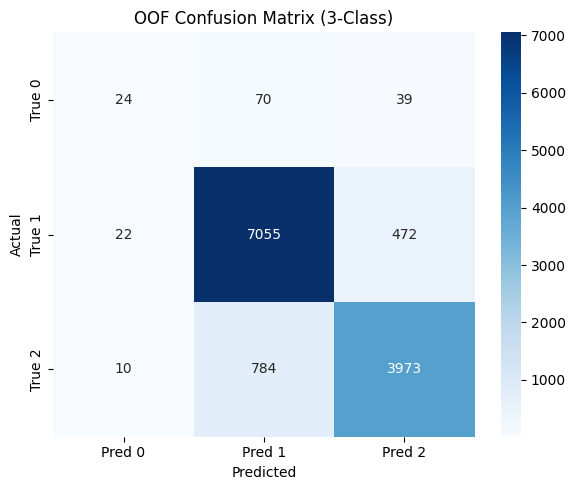

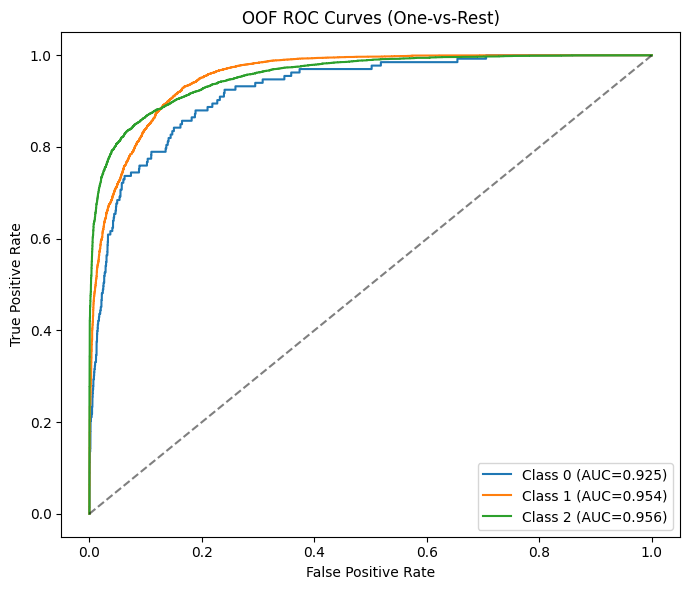

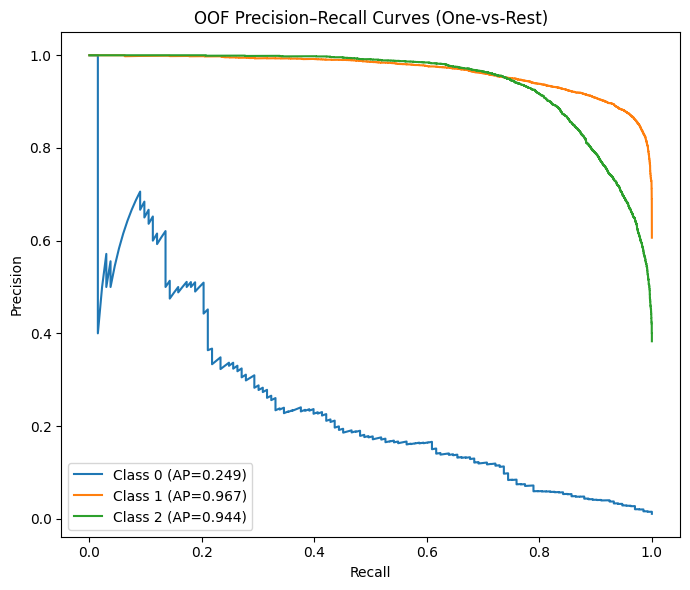

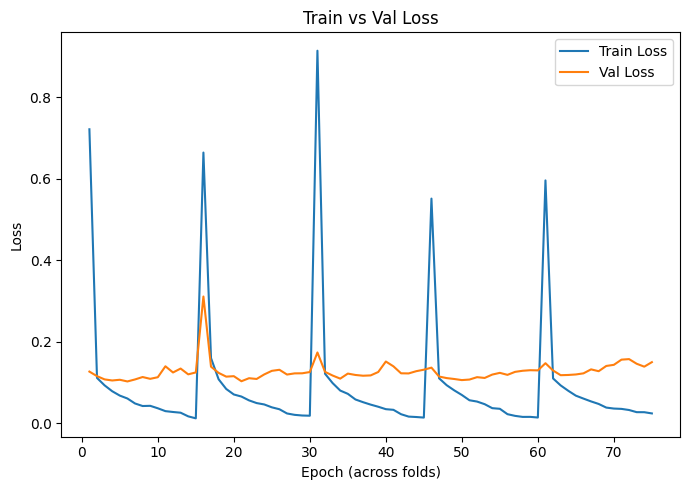

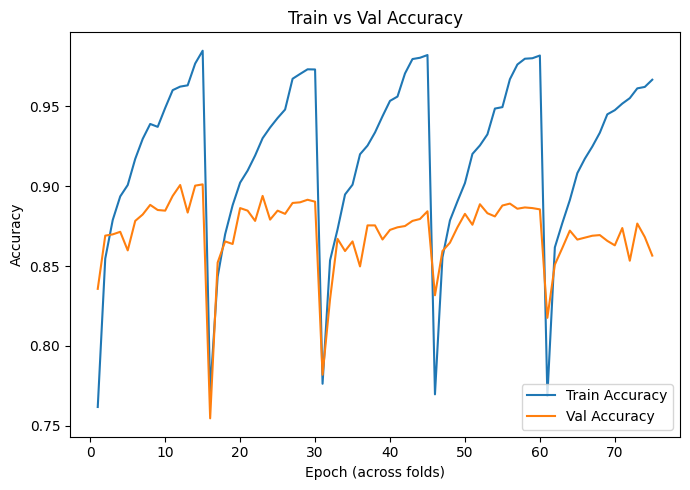

✅ Saved:
  CM heatmap:           /content/drive/MyDrive/Glaucoma detection/figures/oof_confusion_matrix_multiclass.png
  Multi-class ROC:      /content/drive/MyDrive/Glaucoma detection/figures/oof_roc_multiclass.png
  Multi-class PR:       /content/drive/MyDrive/Glaucoma detection/figures/oof_pr_multiclass.png
  Loss curve:           /content/drive/MyDrive/Glaucoma detection/figures/train_val_loss_curve.png
  Accuracy curve:       /content/drive/MyDrive/Glaucoma detection/figures/train_val_accuracy_curve.png


In [ ]:
# Step 8: Final Evaluation — Multi-Class OOF AUC, Report, CM, ROC/PR Curves + Train/Val Curves

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

print("\n--- Final Model Evaluation (from OOF Predictions, 3-Class) ---")

all_labels = np.asarray(oof_labels).astype(int)          
all_preds_probs = np.asarray(oof_preds).astype(float)   

num_classes = all_preds_probs.shape[1]
class_indices = list(range(num_classes))

row_sums = all_preds_probs.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
all_preds_probs = all_preds_probs / row_sums
all_preds_probs = np.clip(all_preds_probs, 1e-7, 1.0 - 1e-7)

# ROC AUC (OVR)
try:
    oof_auc = roc_auc_score(all_labels, all_preds_probs, multi_class="ovr")
except ValueError as e:
    print("[AUC error]", e)
    oof_auc = float("nan")

print(f"Overall OOF ROC AUC (OVR): {oof_auc:.4f}")

# Predicted classes via argmax
all_preds_classes = all_preds_probs.argmax(axis=1)

# Classification report
print("\n--- Classification Report (Argmax over 3 classes) ---")
target_names = [f"Class {i}" for i in class_indices]  # or custom names
print(classification_report(all_labels, all_preds_classes, target_names=target_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds_classes, labels=class_indices)
print("Confusion Matrix (rows = true, cols = pred):\n", cm)

fig_dir = os.path.join(config.BASE_PATH, "figures")
os.makedirs(fig_dir, exist_ok=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"Pred {i}" for i in class_indices],
    yticklabels=[f"True {i}" for i in class_indices]
)
plt.title("OOF Confusion Matrix (3-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
cm_path = os.path.join(fig_dir, "oof_confusion_matrix_multiclass.png")
plt.savefig(cm_path, dpi=150)
plt.show()

Y_bin = label_binarize(all_labels, classes=class_indices)  # shape: (N, C)

# ROC curves
plt.figure(figsize=(7, 6))
for c in class_indices:
    try:
        fpr, tpr, _ = roc_curve(Y_bin[:, c], all_preds_probs[:, c])
        auc_c = roc_auc_score(Y_bin[:, c], all_preds_probs[:, c])
        plt.plot(fpr, tpr, label=f"Class {c} (AUC={auc_c:.3f})")
    except ValueError:
        print(f"(Info) Could not compute ROC for class {c} (maybe only one label present).")

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOF ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = os.path.join(fig_dir, "oof_roc_multiclass.png")
plt.savefig(roc_path, dpi=150)
plt.show()

# PR curves
plt.figure(figsize=(7, 6))
for c in class_indices:
    try:
        precision, recall, _ = precision_recall_curve(Y_bin[:, c], all_preds_probs[:, c])
        ap_c = average_precision_score(Y_bin[:, c], all_preds_probs[:, c])
        plt.plot(recall, precision, label=f"Class {c} (AP={ap_c:.3f})")
    except ValueError:
        print(f"(Info) Could not compute PR curve for class {c}.")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("OOF Precision–Recall Curves (One-vs-Rest)")
plt.legend(loc="lower left")
plt.tight_layout()
pr_path = os.path.join(fig_dir, "oof_pr_multiclass.png")
plt.savefig(pr_path, dpi=150)
plt.show()

# 8) Train vs Val Loss & Accuracy Curves (across all folds/epochs)

epochs = np.arange(1, len(history_train_loss) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, history_train_loss, label="Train Loss")
plt.plot(epochs, history_val_loss, label="Val Loss")
plt.xlabel("Epoch (across folds)")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.tight_layout()
loss_curve_path = os.path.join(fig_dir, "train_val_loss_curve.png")
plt.savefig(loss_curve_path, dpi=150)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs, history_train_acc, label="Train Accuracy")
plt.plot(epochs, history_val_acc, label="Val Accuracy")
plt.xlabel("Epoch (across folds)")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.tight_layout()
acc_curve_path = os.path.join(fig_dir, "train_val_accuracy_curve.png")
plt.savefig(acc_curve_path, dpi=150)
plt.show()

print("✅ Saved:")
print(f"  CM heatmap:           {cm_path}")
print(f"  Multi-class ROC:      {roc_path}")
print(f"  Multi-class PR:       {pr_path}")
print(f"  Loss curve:           {loss_curve_path}")
print(f"  Accuracy curve:       {acc_curve_path}")


In [ ]:
import os
import torch

def load_trained_model_for_fold(fold, device):
    
    ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
    ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{fold}.pth")

    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    model = get_model(config.MODEL_NAME, pretrained=False)
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

print("\n--- Rebuilding OOF predictions from saved fold checkpoints ---")

num_classes = 3  

oof_labels = np.zeros(len(main_df), dtype=int)
oof_preds  = np.zeros((len(main_df), num_classes), dtype=float)

skf = StratifiedKFold(
    n_splits=config.N_SPLITS,
    shuffle=True,
    random_state=config.RANDOM_STATE,
)

X = main_df
y = main_df["label"].values

pin_memory = (config.DEVICE == "cuda")
num_workers = 8
prefetch_factor = 4
persistent_workers = pin_memory and num_workers > 0

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    print(f"\n=== Inference Fold {fold_idx}/{config.N_SPLITS} ===")

    val_df = main_df.iloc[val_idx].reset_index(drop=True)

    val_dataset = GlaucomaDataset(val_df, transform=data_transforms["val"])
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor,
    )
    model = load_trained_model_for_fold(fold_idx, config.DEVICE)

    fold_probs_list = []
    fold_labels_list = []

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Fold {fold_idx} inference", leave=False)
        for inputs, labels in loop:
            inputs = inputs.to(config.DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
            labels = labels.to(config.DEVICE, non_blocking=True).long()

            with torch.amp.autocast("cuda", enabled=(config.DEVICE == "cuda")):
                logits = model(inputs)             
                probs = torch.softmax(logits, dim=1)

            fold_probs_list.append(probs.cpu().numpy())
            fold_labels_list.append(labels.cpu().numpy())

    fold_probs = np.concatenate(fold_probs_list, axis=0)   
    fold_labels = np.concatenate(fold_labels_list, axis=0) 

    assert len(val_idx) == len(fold_labels) == fold_probs.shape[0], \
        f"Length mismatch in fold {fold_idx}"

    oof_labels[val_idx] = fold_labels
    oof_preds[val_idx, :] = fold_probs

print("\n✅ Finished rebuilding OOF predictions from all folds.")
print("Shapes -> labels:", oof_labels.shape, "preds:", oof_preds.shape)



--- Rebuilding OOF predictions from saved fold checkpoints ---

=== Inference Fold 1/5 ===



=== Inference Fold 2/5 ===



=== Inference Fold 3/5 ===



=== Inference Fold 4/5 ===



=== Inference Fold 5/5 ===



✅ Finished rebuilding OOF predictions from all folds.
Shapes -> labels: (12449,) preds: (12449, 3)



--- Final Model Evaluation (from OOF Predictions, 3-Class) ---
Overall OOF ROC AUC (OVR): 0.9451

--- Classification Report (Argmax over 3 classes) ---
              precision    recall  f1-score   support

     Class 0       0.43      0.18      0.25       133
     Class 1       0.89      0.93      0.91      7549
     Class 2       0.89      0.83      0.86      4767

    accuracy                           0.89     12449
   macro avg       0.74      0.65      0.68     12449
weighted avg       0.88      0.89      0.89     12449

Confusion Matrix (rows = true, cols = pred):
 [[  24   70   39]
 [  22 7055  472]
 [  10  785 3972]]


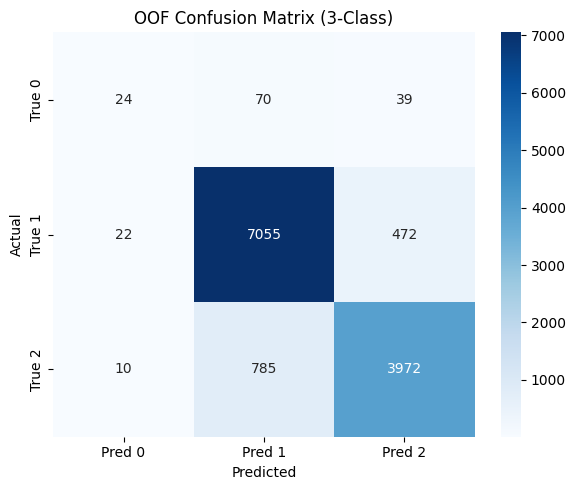

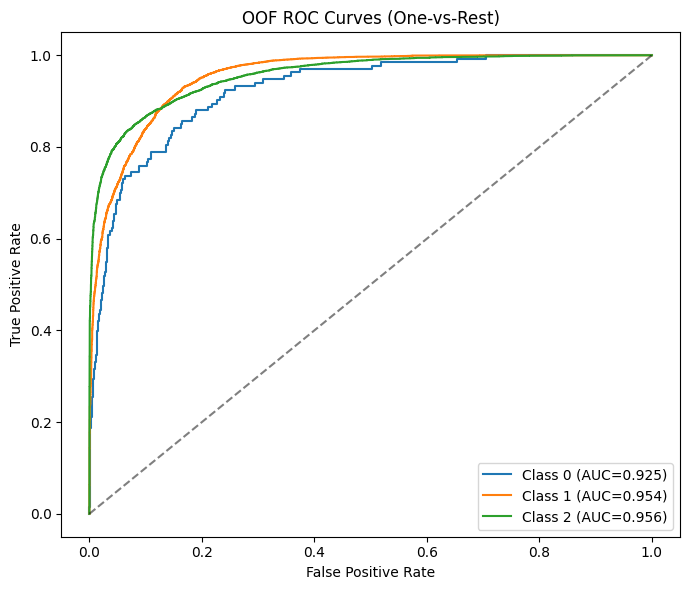

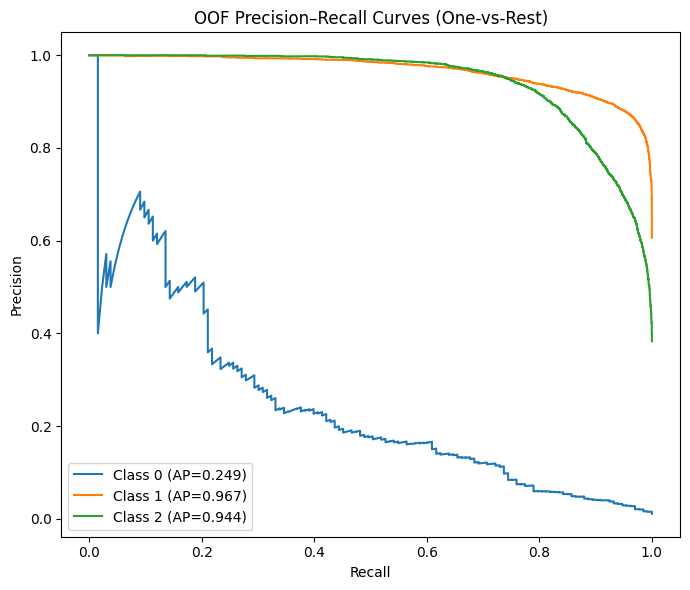

NameError: name 'history_train_loss' is not defined

In [ ]:
# Step 8: Final Evaluation — Multi-Class OOF AUC, Report, CM, ROC/PR Curves + Train/Val Curves

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

print("\n--- Final Model Evaluation (from OOF Predictions, 3-Class) ---")

all_labels = np.asarray(oof_labels).astype(int)          
all_preds_probs = np.asarray(oof_preds).astype(float)   

num_classes = all_preds_probs.shape[1]
class_indices = list(range(num_classes))

row_sums = all_preds_probs.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
all_preds_probs = all_preds_probs / row_sums
all_preds_probs = np.clip(all_preds_probs, 1e-7, 1.0 - 1e-7)

try:
    oof_auc = roc_auc_score(all_labels, all_preds_probs, multi_class="ovr")
except ValueError as e:
    print("[AUC error]", e)
    oof_auc = float("nan")

print(f"Overall OOF ROC AUC (OVR): {oof_auc:.4f}")

all_preds_classes = all_preds_probs.argmax(axis=1)

print("\n--- Classification Report (Argmax over 3 classes) ---")
target_names = [f"Class {i}" for i in class_indices]  # or custom names
print(classification_report(all_labels, all_preds_classes, target_names=target_names, zero_division=0))

cm = confusion_matrix(all_labels, all_preds_classes, labels=class_indices)
print("Confusion Matrix (rows = true, cols = pred):\n", cm)

fig_dir = os.path.join(config.BASE_PATH, "figures")
os.makedirs(fig_dir, exist_ok=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"Pred {i}" for i in class_indices],
    yticklabels=[f"True {i}" for i in class_indices]
)
plt.title("OOF Confusion Matrix (3-Class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
cm_path = os.path.join(fig_dir, "oof_confusion_matrix_multiclass.png")
plt.savefig(cm_path, dpi=150)
plt.show()

Y_bin = label_binarize(all_labels, classes=class_indices)  # shape: (N, C)

plt.figure(figsize=(7, 6))
for c in class_indices:
    try:
        fpr, tpr, _ = roc_curve(Y_bin[:, c], all_preds_probs[:, c])
        auc_c = roc_auc_score(Y_bin[:, c], all_preds_probs[:, c])
        plt.plot(fpr, tpr, label=f"Class {c} (AUC={auc_c:.3f})")
    except ValueError:
        print(f"(Info) Could not compute ROC for class {c} (maybe only one label present).")

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOF ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = os.path.join(fig_dir, "oof_roc_multiclass.png")
plt.savefig(roc_path, dpi=150)
plt.show()

plt.figure(figsize=(7, 6))
for c in class_indices:
    try:
        precision, recall, _ = precision_recall_curve(Y_bin[:, c], all_preds_probs[:, c])
        ap_c = average_precision_score(Y_bin[:, c], all_preds_probs[:, c])
        plt.plot(recall, precision, label=f"Class {c} (AP={ap_c:.3f})")
    except ValueError:
        print(f"(Info) Could not compute PR curve for class {c}.")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("OOF Precision–Recall Curves (One-vs-Rest)")
plt.legend(loc="lower left")
plt.tight_layout()
pr_path = os.path.join(fig_dir, "oof_pr_multiclass.png")
plt.savefig(pr_path, dpi=150)
plt.show()


epochs = np.arange(1, len(history_train_loss) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, history_train_loss, label="Train Loss")
plt.plot(epochs, history_val_loss, label="Val Loss")
plt.xlabel("Epoch (across folds)")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.tight_layout()
loss_curve_path = os.path.join(fig_dir, "train_val_loss_curve.png")
plt.savefig(loss_curve_path, dpi=150)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs, history_train_acc, label="Train Accuracy")
plt.plot(epochs, history_val_acc, label="Val Accuracy")
plt.xlabel("Epoch (across folds)")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.tight_layout()
acc_curve_path = os.path.join(fig_dir, "train_val_accuracy_curve.png")
plt.savefig(acc_curve_path, dpi=150)
plt.show()

print("✅ Saved:")
print(f"  CM heatmap:           {cm_path}")
print(f"  Multi-class ROC:      {roc_path}")
print(f"  Multi-class PR:       {pr_path}")
print(f"  Loss curve:           {loss_curve_path}")
print(f"  Accuracy curve:       {acc_curve_path}")


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import shap  

CHECKPOINT_PATH = "/content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth"

device = torch.device(config.DEVICE if torch.cuda.is_available() else "cpu")
num_classes = 3
class_names = ["Class 0", "Class 1", "Class 2"] 
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

infer_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

def load_trained_model(checkpoint_path):
    model = get_model(config.MODEL_NAME, pretrained=False)
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

model = load_trained_model(CHECKPOINT_PATH)
print("Model loaded for XAI:", CHECKPOINT_PATH)


Model loaded for XAI: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        self.fwd_hook = target_layer.register_forward_hook(self._forward_hook)
        self.bwd_hook = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        logits = self.model(input_tensor)
        probs = F.softmax(logits, dim=1)

        if class_idx is None:
            class_idx = int(probs.argmax(dim=1).item())

        score = logits[0, class_idx]
        score.backward(retain_graph=True)

        activations = self.activations
        gradients = self.gradients

        weights = gradients.mean(dim=(2, 3))
        weights = weights[0]

        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=activations.device)
        for k, w in enumerate(weights):
            cam += w * activations[0, k, :, :]

        cam = F.relu(cam)
        cam -= cam.min()
        cam += 1e-7
        cam /= cam.max()

        cam = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=input_tensor.shape[2:],
            mode="bilinear",
            align_corners=False
        )[0, 0]

        cam = cam.detach().cpu().numpy()
        return cam, probs.detach().cpu().numpy()[0], class_idx

def tensor_to_display_img(tensor):
    img = tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img


In [ ]:
target_layer = model.conv_head  
grad_cam = GradCAM(model, target_layer)


In [ ]:
bg_indices = random.sample(range(len(main_df)), k=min(30, len(main_df)))

def load_image_tensor_from_path(path):
    img = Image.open(path).convert("RGB")
    t = infer_transform(img)
    return t

background_tensors = []
for idx in bg_indices:
    row = main_df.iloc[idx]
    t = load_image_tensor_from_path(row["full_path"])
    background_tensors.append(t)

background_tensors = torch.stack(background_tensors, dim=0).to(device)

import shap
import torch.nn.functional as F

model.eval()

background_tensors = background_tensors.to(device)
background_tensors.requires_grad_(True)

explainer = shap.GradientExplainer(model, background_tensors)
print("SHAP GradientExplainer initialized with background size:", background_tensors.shape[0])


SHAP GradientExplainer initialized with background size: 30


✅ Loaded model from: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
✅ Grad-CAM ready (hooked conv_head).


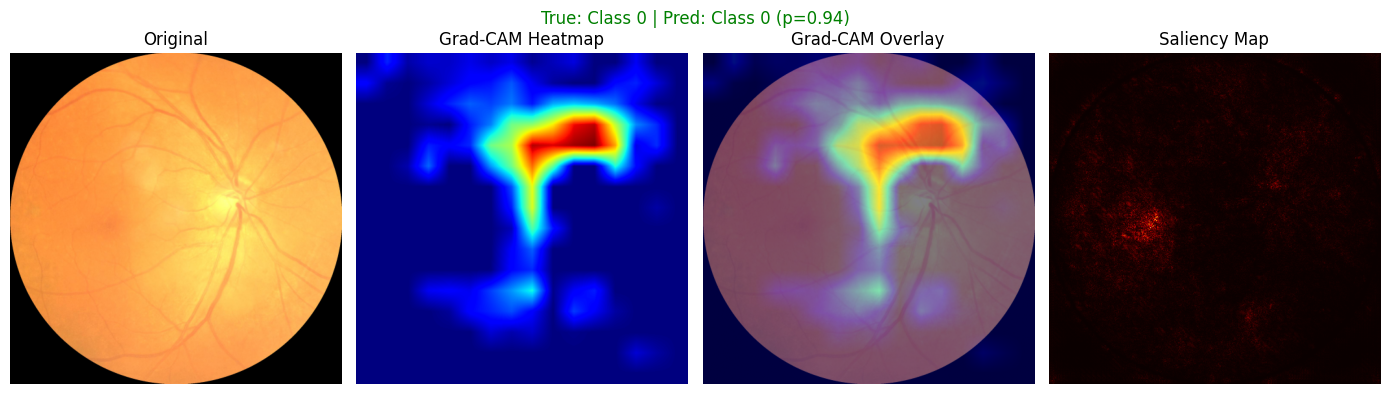


Sample 1/3
  True label index: 1 -> Class 0
  Pred label index: 1  -> Class 0
  Probabilities: [8.3543634e-04 9.4125354e-01 5.7911050e-02]


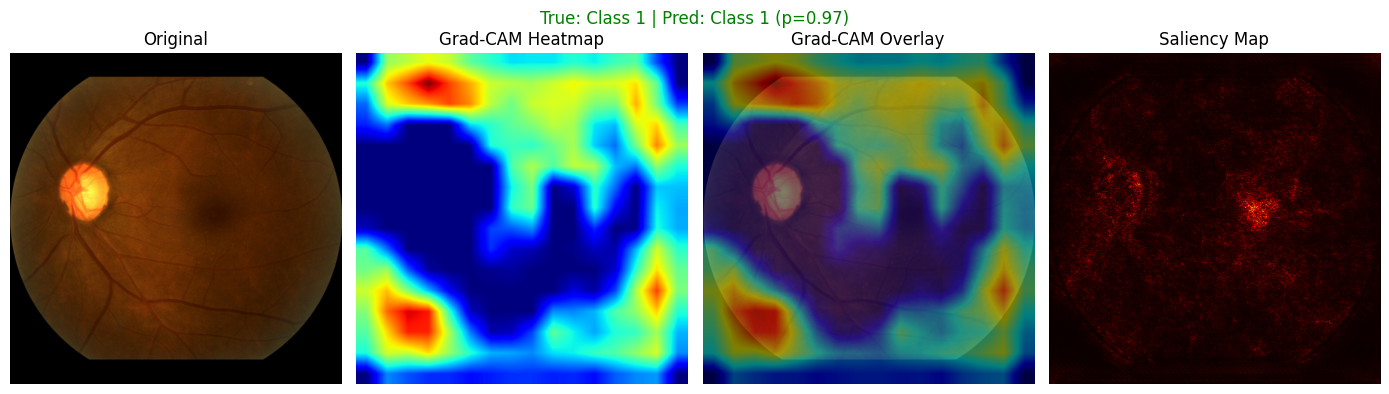


Sample 2/3
  True label index: 2 -> Class 1
  Pred label index: 2  -> Class 1
  Probabilities: [2.3585973e-04 2.6357137e-02 9.7340697e-01]


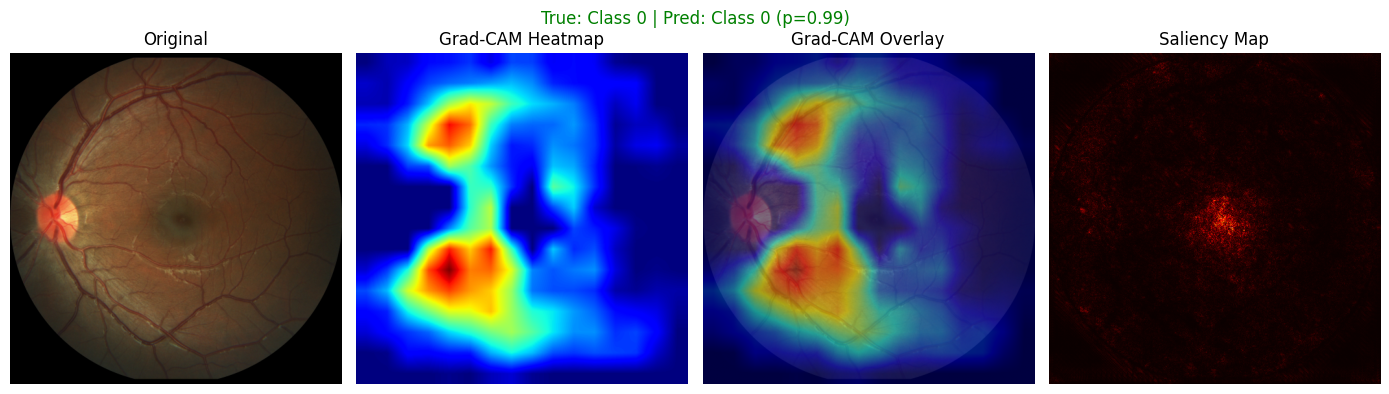


Sample 3/3
  True label index: 1 -> Class 0
  Pred label index: 1  -> Class 0
  Probabilities: [3.7719732e-05 9.9365669e-01 6.3056028e-03]


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

FOLD_TO_USE = 1

device = config.DEVICE
ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{FOLD_TO_USE}.pth")

model = get_model(config.MODEL_NAME, pretrained=False).to(device)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.eval()

print(f"✅ Loaded model from: {ckpt_path}")

num_classes = 3

class_names = {
    0: "Class -1",
    1: "Class 0",
    2: "Class 1",
}

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

def denorm(img_tensor):
    t = img_tensor * IMAGENET_STD + IMAGENET_MEAN
    t = t.clamp(0, 1)
    t = t.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    return t

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        try:
            self.target_layer.register_full_backward_hook(backward_hook)
        except AttributeError:
            self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[0, class_idx]
        score.backward(retain_graph=True)

        grads = self.gradients[0]
        acts  = self.activations[0]

        weights = grads.mean(dim=(1, 2))
        cam = torch.sum(weights.view(-1, 1, 1) * acts, dim=0)

        cam = F.relu(cam)

        if cam.max() > 0:
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-7)

        cam_np = cam.detach().cpu().numpy()
        cam_np = cv2.resize(cam_np, (x.shape[-1], x.shape[-2]))
        return cam_np

target_layer = model.conv_head
grad_cam = GradCAM(model, target_layer)
print("✅ Grad-CAM ready (hooked conv_head).")

def compute_saliency(model, x, class_idx=None):
    x = x.clone().detach().to(device)
    x.requires_grad_(True)
    model.zero_grad()

    logits = model(x)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    score = logits[0, class_idx]
    score.backward()

    grad = x.grad.detach().abs().squeeze(0)
    saliency = grad.max(dim=0)[0]

    saliency = saliency - saliency.min()
    saliency = saliency / (saliency.max() + 1e-7)

    saliency_np = saliency.cpu().numpy()
    return saliency_np

NUM_SAMPLES = 3

sample_df = main_df.sample(n=NUM_SAMPLES, random_state=123).reset_index(drop=True)
sample_dataset = GlaucomaDataset(sample_df, transform=data_transforms["val"])

for i in range(NUM_SAMPLES):
    img_tensor, true_label = sample_dataset[i]
    true_label = int(true_label)

    inp = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(inp)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_prob = float(probs[pred_idx])

    cam_map = grad_cam(inp, class_idx=pred_idx)

    cam_color = cv2.applyColorMap((cam_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
    cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB) / 255.0

    img_vis = denorm(inp.clone())
    overlay_cam = (0.5 * img_vis + 0.5 * cam_color).clip(0, 1)

    saliency_map = compute_saliency(model, inp, class_idx=pred_idx)

    correct = (pred_idx == true_label)
    title_color = "green" if correct else "red"
    title_text = (
        f"True: {class_names.get(true_label, true_label)} | "
        f"Pred: {class_names.get(pred_idx, pred_idx)} (p={pred_prob:.2f})"
    )

    plt.figure(figsize=(14, 4))
    plt.suptitle(title_text, color=title_color, fontsize=12)

    plt.subplot(1, 4, 1)
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1, 4, 2)
    plt.imshow(cam_map, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 4, 3)
    plt.imshow(overlay_cam)
    plt.axis("off")
    plt.title("Grad-CAM Overlay")

    plt.subplot(1, 4, 4)
    plt.imshow(saliency_map, cmap="hot")
    plt.axis("off")
    plt.title("Saliency Map")

    plt.tight_layout()
    plt.show()

    print(f"\nSample {i+1}/{NUM_SAMPLES}")
    print(f"  True label index: {true_label} -> {class_names.get(true_label, true_label)}")
    print(f"  Pred label index: {pred_idx}  -> {class_names.get(pred_idx, pred_idx)}")
    print(f"  Probabilities: {probs}")


✅ Loaded model from: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
📌 Selected 1 image per class: [0, 1, 2]
✅ Grad-CAM ready


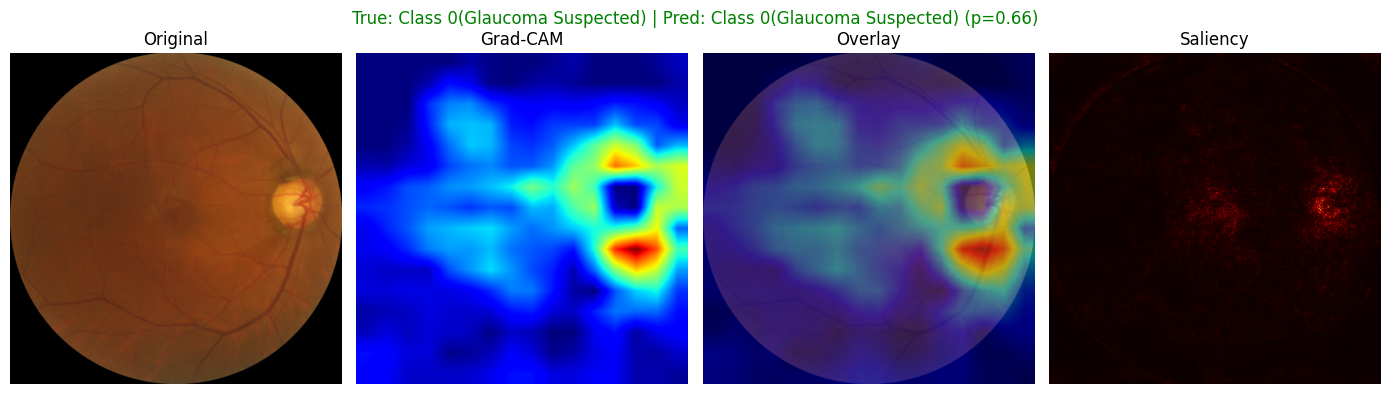

Done → Class 0 sample


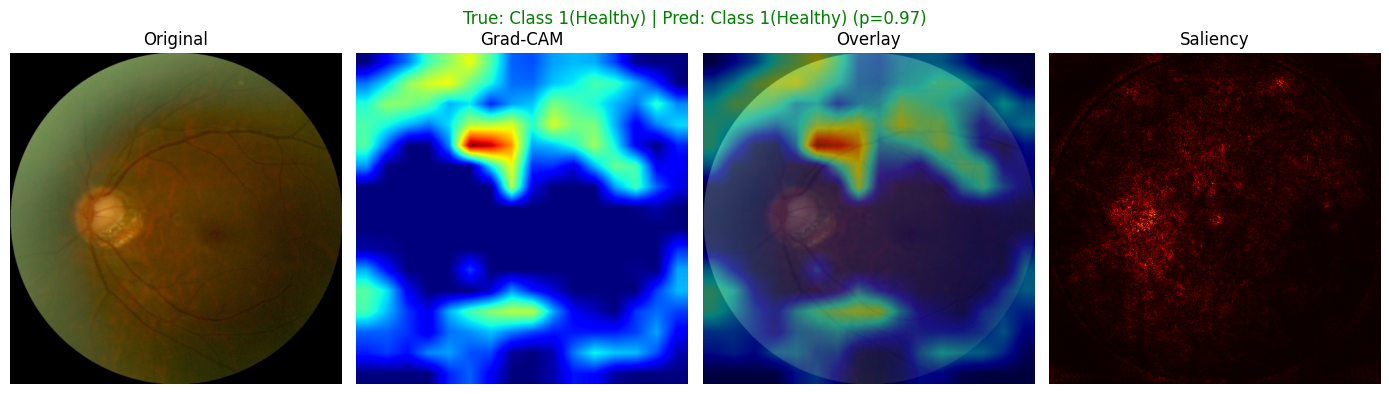

Done → Class 1 sample


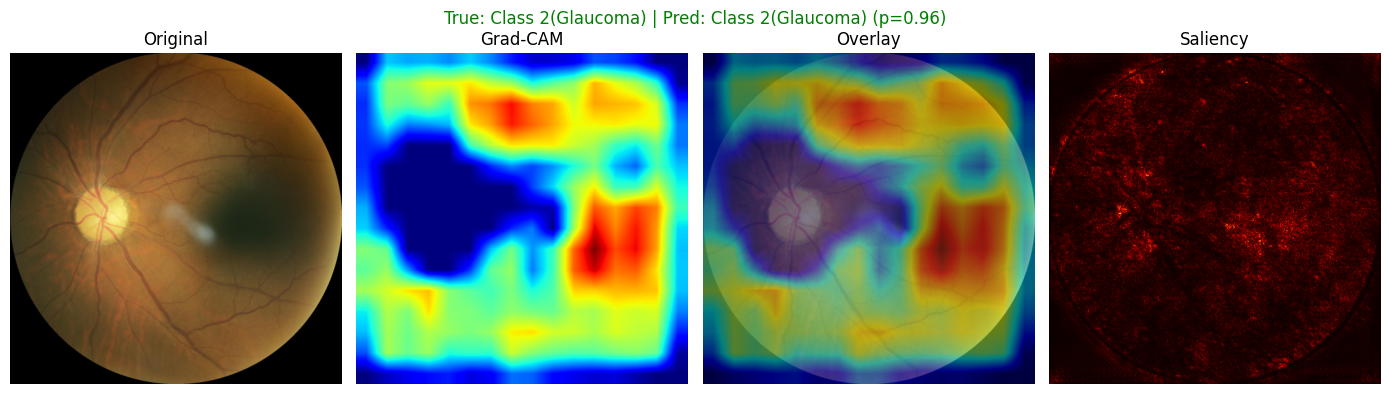

Done → Class 2 sample


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F

FOLD_TO_USE = 1
device = config.DEVICE

ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{FOLD_TO_USE}.pth")

model = get_model(config.MODEL_NAME, pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print(f"✅ Loaded model from: {ckpt_path}")

class_names = {
    0: "Class 0(Glaucoma Suspected)",
    1: "Class 1(Healthy)",
    2: "Class 2(Glaucoma)",
}

num_classes = 3

samples = []
for cls in range(num_classes):
    row = main_df[main_df["label"] == cls].sample(1, random_state=123)
    samples.append(row)

import pandas as pd
samples_df = pd.concat(samples, ignore_index=True)

sample_dataset = GlaucomaDataset(samples_df, transform=data_transforms["val"])

print("📌 Selected 1 image per class:", samples_df["label"].tolist())

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def denorm(img):
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = img.clamp(0,1)
    img = img.squeeze(0).permute(1,2,0).cpu().numpy()
    return img

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target = target_layer
        self.activations = None
        self.gradients = None
        self._hook()

    def _hook(self):
        self.target.register_forward_hook(
            lambda m, i, o: setattr(self, "activations", o)
        )
        try:
            self.target.register_full_backward_hook(
                lambda m, gi, go: setattr(self, "gradients", go[0])
            )
        except:
            self.target.register_backward_hook(
                lambda m, gi, go: setattr(self, "gradients", go[0])
            )

    def __call__(self, x, class_idx):
        self.model.zero_grad()

        logits = self.model(x)
        score = logits[0, class_idx]
        score.backward()

        act = self.activations[0]
        grad = self.gradients[0]

        weights = grad.mean(dim=(1,2))

        cam = (weights[:, None, None] * act).sum(dim=0)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-7)

        cam = cam.detach().cpu().numpy()
        cam = cv2.resize(cam, (x.shape[-1], x.shape[-2]))
        return cam

grad_cam = GradCAM(model, model.conv_head)
print("✅ Grad-CAM ready")

def saliency_map(model, x, target):
    x = x.clone().detach().to(device)
    x.requires_grad_(True)
    logits = model(x)
    logits[0, target].backward()
    grad = x.grad.abs().squeeze(0)
    sal = grad.max(0)[0]
    sal -= sal.min()
    sal /= (sal.max()+1e-7)
    return sal.cpu().numpy()

for idx in range(num_classes):

    img_t, true_label = sample_dataset[idx]
    true_label = int(true_label)

    x = img_t.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits,1)[0].cpu().numpy()
        pred = int(np.argmax(probs))
        pred_prob = probs[pred]

    cam = grad_cam(x, pred)

    cam_color = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)/255.0

    img_vis = denorm(x)

    overlay = (0.5 * img_vis + 0.5 * cam_color).clip(0,1)

    sal = saliency_map(model, x, pred)

    correct = (pred == true_label)
    title_color = "green" if correct else "red"
    title_text = (
        f"True: {class_names[true_label]} | "
        f"Pred: {class_names[pred]} (p={pred_prob:.2f})"
    )

    plt.figure(figsize=(14,4))
    plt.suptitle(title_text, color=title_color, fontsize=12)

    plt.subplot(1,4,1)
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1,4,2)
    plt.imshow(cam, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM")

    plt.subplot(1,4,3)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay")

    plt.subplot(1,4,4)
    plt.imshow(sal, cmap="hot")
    plt.axis("off")
    plt.title("Saliency")

    plt.tight_layout()
    plt.show()

    print(f"Done → Class {true_label} sample")


✅ Loaded model from: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
📌 Selected 1 image per class (labels): [0, 1, 2]
📌 Selected image paths:
['/content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus/OIA-ODIR-TRAIN-658.png', '/content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus/OIA-ODIR-TRAIN-1229.png', '/content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus/EyePACS-Glaucoma-3157.png']
✅ Grad-CAM ready


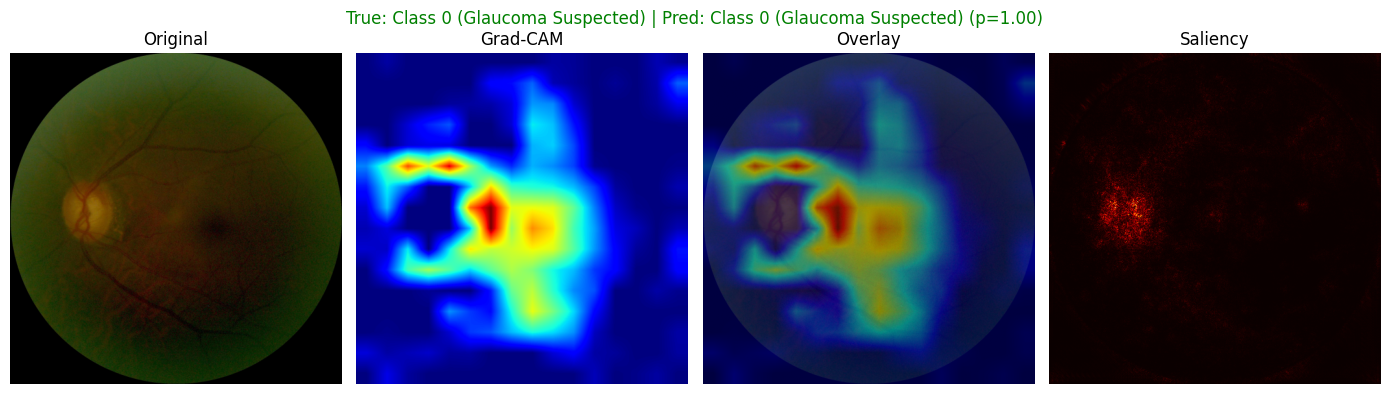

✅ Done → sample with true label 0


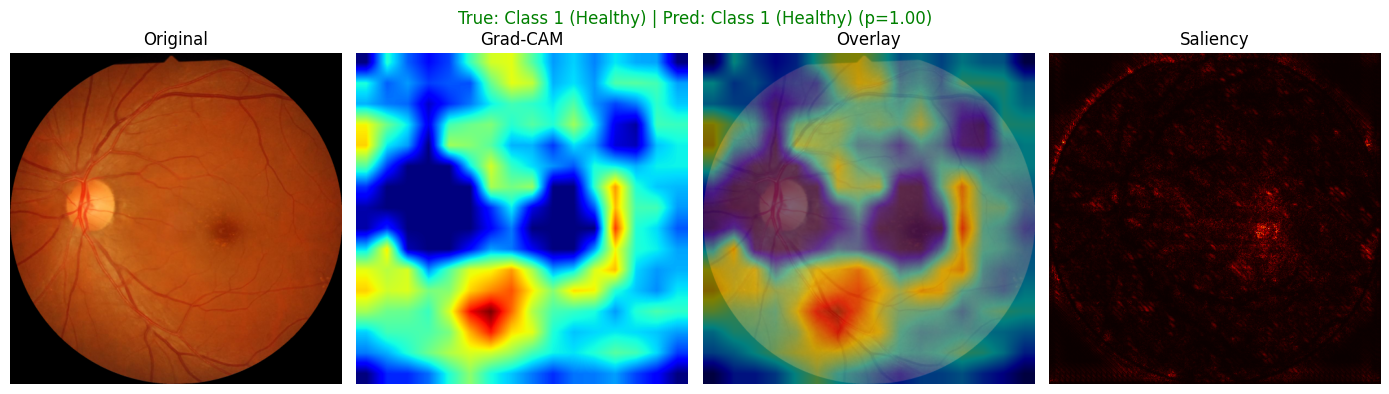

✅ Done → sample with true label 1


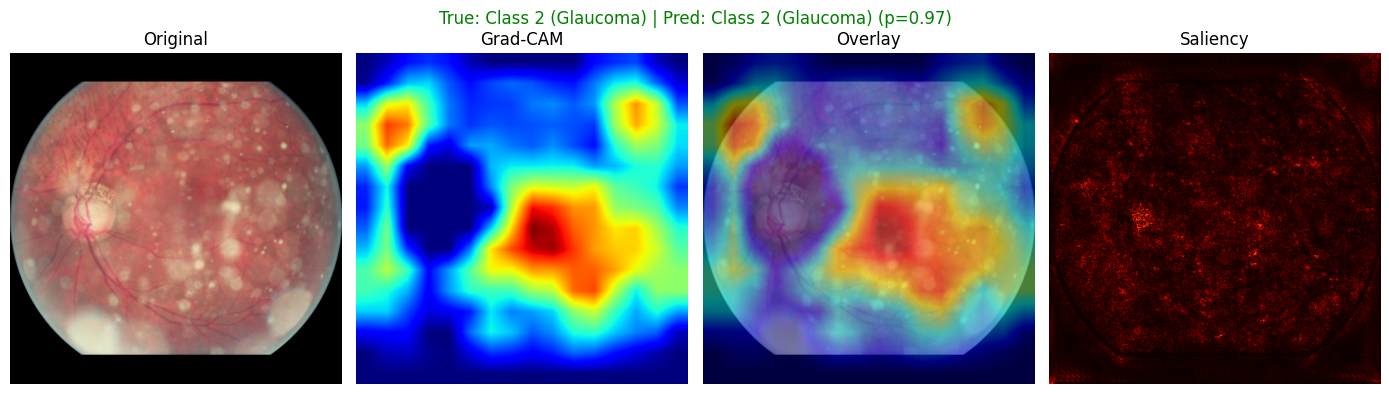

✅ Done → sample with true label 2


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F

FOLD_TO_USE = 1
device = config.DEVICE

ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{FOLD_TO_USE}.pth")

model = get_model(config.MODEL_NAME, pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print(f"✅ Loaded model from: {ckpt_path}")

class_names = {
    0: "Class 0(Glaucoma Suspected)",
    1: "Class 1(Healthy)",
    2: "Class 2(Glaucoma)",
}

num_classes = 3

samples = []
for cls in range(num_classes):
    row = main_df[main_df["label"] == cls].sample(1, random_state=123)
    samples.append(row)

import pandas as pd
samples_df = pd.concat(samples, ignore_index=True)

sample_dataset = GlaucomaDataset(samples_df, transform=data_transforms["val"])

print("📌 Selected 1 image per class:", samples_df["label"].tolist())

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def denorm(img):
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = img.clamp(0,1)
    img = img.squeeze(0).permute(1,2,0).cpu().numpy()
    return img

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target = target_layer
        self.activations = None
        self.gradients = None
        self._hook()

    def _hook(self):
        self.target.register_forward_hook(
            lambda m, i, o: setattr(self, "activations", o)
        )
        try:
            self.target.register_full_backward_hook(
                lambda m, gi, go: setattr(self, "gradients", go[0])
            )
        except:
            self.target.register_backward_hook(
                lambda m, gi, go: setattr(self, "gradients", go[0])
            )

    def __call__(self, x, class_idx):
        self.model.zero_grad()

        logits = self.model(x)
        score = logits[0, class_idx]
        score.backward()

        act = self.activations[0]
        grad = self.gradients[0]

        weights = grad.mean(dim=(1,2))

        cam = (weights[:, None, None] * act).sum(dim=0)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-7)

        cam = cam.detach().cpu().numpy()
        cam = cv2.resize(cam, (x.shape[-1], x.shape[-2]))
        return cam

grad_cam = GradCAM(model, model.conv_head)
print("✅ Grad-CAM ready")

def saliency_map(model, x, target):
    x = x.clone().detach().to(device)
    x.requires_grad_(True)
    logits = model(x)
    logits[0, target].backward()
    grad = x.grad.abs().squeeze(0)
    sal = grad.max(0)[0]
    sal -= sal.min()
    sal /= (sal.max()+1e-7)
    return sal.cpu().numpy()

for idx in range(num_classes):

    img_t, true_label = sample_dataset[idx]
    true_label = int(true_label)

    x = img_t.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits,1)[0].cpu().numpy()
        pred = int(np.argmax(probs))
        pred_prob = probs[pred]

    cam = grad_cam(x, pred)

    cam_color = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)/255.0

    img_vis = denorm(x)

    overlay = (0.5 * img_vis + 0.5 * cam_color).clip(0,1)

    sal = saliency_map(model, x, pred)

    correct = (pred == true_label)
    title_color = "green" if correct else "red"
    title_text = (
        f"True: {class_names[true_label]} | "
        f"Pred: {class_names[pred]} (p={pred_prob:.2f})"
    )

    plt.figure(figsize=(14,4))
    plt.suptitle(title_text, color=title_color, fontsize=12)

    plt.subplot(1,4,1)
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1,4,2)
    plt.imshow(cam, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM")

    plt.subplot(1,4,3)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay")

    plt.subplot(1,4,4)
    plt.imshow(sal, cmap="hot")
    plt.axis("off")
    plt.title("Saliency")

    plt.tight_layout()
    plt.show()

    print(f"Done → Class {true_label} sample")


SHAP

✅ Loaded model from: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Background tensor shape for SHAP: torch.Size([32, 3, 512, 512])
✅ SHAP GradientExplainer initialized.
🎯 Random sample:
  Path: /content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus/G1020-497.png
  True label: 1 | Healthy

🔮 Prediction probabilities:
  P(Glaucoma Suspected): 0.0000
  P(Healthy): 0.8638
  P(Glaucoma): 0.1362
  → Pred: Healthy (class 1), p=0.8638

shap_raw.shape: (1, 3, 512, 512, 3)
shap_values_all.shape: (3, 512, 512, 3)


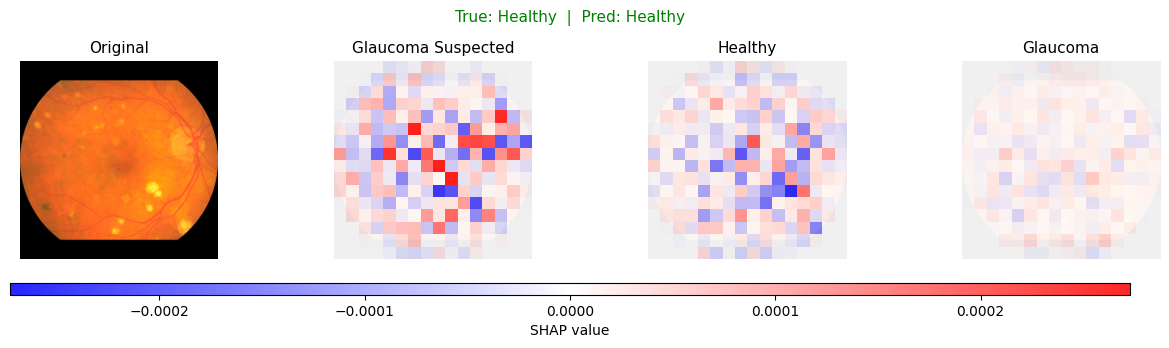

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import shap

device = config.DEVICE
num_classes = 3

FOLD_TO_USE = 1

ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{FOLD_TO_USE}.pth")

model = get_model(config.MODEL_NAME, pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print(f"✅ Loaded model from: {ckpt_path}")

class_names = {
    0: "Glaucoma Suspected",
    1: "Healthy",
    2: "Glaucoma",
}

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

def denorm(img):
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = img.clamp(0, 1)
    img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    return img

BG_SIZE = 32

if len(main_df) < BG_SIZE:
    bg_df = main_df.sample(len(main_df), random_state=42)
else:
    bg_df = main_df.sample(BG_SIZE, random_state=42)

bg_dataset = GlaucomaDataset(bg_df.reset_index(drop=True),
                             transform=data_transforms["val"])

bg_imgs = []
for i in range(len(bg_dataset)):
    img_t, _ = bg_dataset[i]
    bg_imgs.append(img_t)

background_tensors = torch.stack(bg_imgs, dim=0).to(device)
print("Background tensor shape for SHAP:", background_tensors.shape)

explainer = shap.GradientExplainer(model, background_tensors)
print("✅ SHAP GradientExplainer initialized.")

row = main_df.sample(1, random_state=None)
true_label = int(row["label"].values[0])
img_path   = row["full_path"].values[0]

test_dataset = GlaucomaDataset(row.reset_index(drop=True),
                               transform=data_transforms["val"])
x_test, y_test = test_dataset[0]
y_test = int(y_test)

x_test = x_test.unsqueeze(0).to(device)

print("🎯 Random sample:")
print("  Path:", img_path)
print("  True label:", true_label, "|", class_names.get(true_label, true_label))

with torch.no_grad():
    logits = model(x_test)
    probs = F.softmax(logits, dim=1)[0].cpu().numpy()

pred_class = int(np.argmax(probs))
pred_prob  = probs[pred_class]

print("\n🔮 Prediction probabilities:")
for c in range(num_classes):
    print(f"  P({class_names.get(c, c)}): {probs[c]:.4f}")
print(f"  → Pred: {class_names.get(pred_class, pred_class)} (class {pred_class}), p={pred_prob:.4f}")

shap_raw = explainer.shap_values(x_test)
shap_raw = np.array(shap_raw)
print("\nshap_raw.shape:", shap_raw.shape)

if shap_raw.ndim == 5 and shap_raw.shape[0] == 1:
    shap_values_all = shap_raw[0]
else:
    shap_values_all = shap_raw

print("shap_values_all.shape:", shap_values_all.shape)

img_vis = denorm(x_test)
H, W, _ = img_vis.shape

grid_size = 16
shap_maps_blocky = []
max_abs = 0.0

for c in range(num_classes):
    sv = shap_values_all[c].mean(axis=-1)

    sv_small = cv2.resize(sv, (grid_size, grid_size),
                          interpolation=cv2.INTER_AREA)
    sv_block = cv2.resize(sv_small, (W, H),
                          interpolation=cv2.INTER_NEAREST)

    shap_maps_blocky.append(sv_block)
    max_abs = max(max_abs, np.abs(sv_block).max())

if max_abs == 0:
    max_abs = 1e-7

fig, axes = plt.subplots(1, num_classes + 1,
                         figsize=(4*(num_classes+1), 3))

suptitle_color = "green" if pred_class == true_label else "red"

fig.suptitle(
    f"True: {class_names.get(true_label, true_label)}  |  "
    f"Pred: {class_names.get(pred_class, pred_class)}\n",
    color=suptitle_color,
    fontsize=11,
    y=1.05
)

axes[0].imshow(img_vis)
axes[0].axis("off")
axes[0].set_title("Original", fontsize=11)

for c in range(num_classes):
    ax = axes[c+1]

    ax.imshow(img_vis, alpha=0.35)

    im = ax.imshow(
        shap_maps_blocky[c],
        cmap="bwr",
        vmin=-max_abs,
        vmax= max_abs,
        alpha=0.85,
        interpolation="nearest"
    )
    ax.axis("off")
    ax.set_title(class_names.get(c, f"Class {c}"), fontsize=11)

plt.subplots_adjust(bottom=0.22, wspace=0.05)

cbar_ax = fig.add_axes([0.15, 0.10, 0.7, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("SHAP value")

plt.show()


✅ Loaded model from: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Background tensor shape for SHAP: torch.Size([32, 3, 512, 512])
✅ SHAP GradientExplainer initialized.
🎯 Random sample:
  Path: /content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus/G1020-81.png
  True label: 2 | Glaucoma

🔮 Prediction probabilities:
  P(Glaucoma Suspected): 0.0001
  P(Healthy): 0.3702
  P(Glaucoma): 0.6297
  → Pred: Glaucoma (class 2), p=0.6297

shap_raw.shape: (1, 3, 512, 512, 3)
shap_values_all.shape: (3, 512, 512, 3)


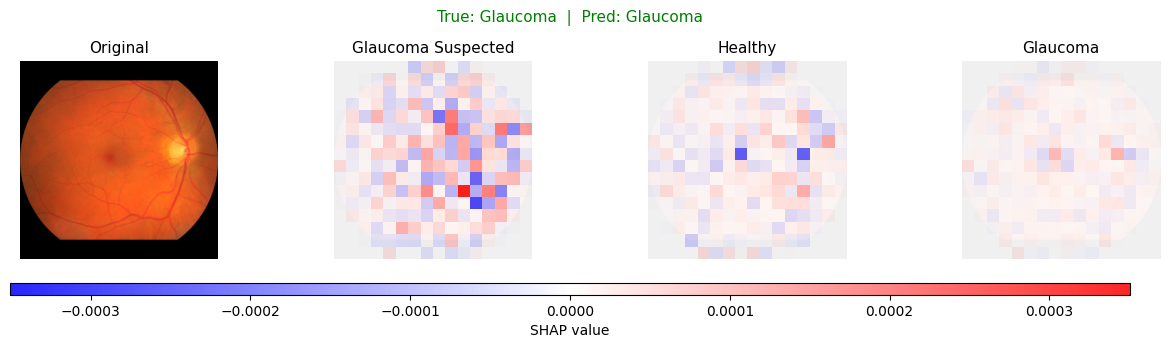

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import shap

device = config.DEVICE
num_classes = 3

FOLD_TO_USE = 1

ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{FOLD_TO_USE}.pth")

model = get_model(config.MODEL_NAME, pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print(f"✅ Loaded model from: {ckpt_path}")

class_names = {
    0: "Glaucoma Suspected",
    1: "Healthy",
    2: "Glaucoma",
}

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

def denorm(img):
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = img.clamp(0, 1)
    img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    return img

BG_SIZE = 32

if len(main_df) < BG_SIZE:
    bg_df = main_df.sample(len(main_df), random_state=42)
else:
    bg_df = main_df.sample(BG_SIZE, random_state=42)

bg_dataset = GlaucomaDataset(bg_df.reset_index(drop=True),
                             transform=data_transforms["val"])

bg_imgs = []
for i in range(len(bg_dataset)):
    img_t, _ = bg_dataset[i]
    bg_imgs.append(img_t)

background_tensors = torch.stack(bg_imgs, dim=0).to(device)  # (B,3,H,W)
print("Background tensor shape for SHAP:", background_tensors.shape)

explainer = shap.GradientExplainer(model, background_tensors)
print("✅ SHAP GradientExplainer initialized.")

row = main_df.sample(1, random_state=None)
true_label = int(row["label"].values[0])
img_path   = row["full_path"].values[0]

test_dataset = GlaucomaDataset(row.reset_index(drop=True),
                               transform=data_transforms["val"])
x_test, y_test = test_dataset[0]
y_test = int(y_test)

x_test = x_test.unsqueeze(0).to(device)  # (1,3,H,W)

print("🎯 Random sample:")
print("  Path:", img_path)
print("  True label:", true_label, "|", class_names.get(true_label, true_label))


with torch.no_grad():
    logits = model(x_test)
    probs = F.softmax(logits, dim=1)[0].cpu().numpy()

pred_class = int(np.argmax(probs))
pred_prob  = probs[pred_class]

print("\n🔮 Prediction probabilities:")
for c in range(num_classes):
    print(f"  P({class_names.get(c, c)}): {probs[c]:.4f}")
print(f"  → Pred: {class_names.get(pred_class, pred_class)} (class {pred_class}), p={pred_prob:.4f}")

shap_raw = explainer.shap_values(x_test)
shap_raw = np.array(shap_raw)
print("\nshap_raw.shape:", shap_raw.shape)

if shap_raw.ndim == 5 and shap_raw.shape[0] == 1:
    shap_values_all = shap_raw[0]     # (3, H, W, 3)
else:
    shap_values_all = shap_raw        # fallback

print("shap_values_all.shape:", shap_values_all.shape)

img_vis = denorm(x_test)              # (H,W,3)
H, W, _ = img_vis.shape

grid_size = 16    # coarse grid like the paper (try 16 or 24)
shap_maps_blocky = []
max_abs = 0.0

for c in range(num_classes):
    # (H,W,3) -> mean over channels -> (H,W)
    sv = shap_values_all[c].mean(axis=-1)

    # downsample to coarse grid
    sv_small = cv2.resize(sv, (grid_size, grid_size),
                          interpolation=cv2.INTER_AREA)
    # upsample back to full size with nearest -> chunky blocks
    sv_block = cv2.resize(sv_small, (W, H),
                          interpolation=cv2.INTER_NEAREST)

    shap_maps_blocky.append(sv_block)
    max_abs = max(max_abs, np.abs(sv_block).max())

if max_abs == 0:
    max_abs = 1e-7

fig, axes = plt.subplots(1, num_classes + 1,
                         figsize=(4*(num_classes+1), 3))

# Global title (True | Pred same line, visual gap below)
suptitle_color = "green" if pred_class == true_label else "red"

fig.suptitle(
    f"True: {class_names.get(true_label, true_label)}  |  "
    f"Pred: {class_names.get(pred_class, pred_class)}\n",  # <-- gap added
    color=suptitle_color,
    fontsize=11,
    y=1.05   # <-- push title up slightly to reveal the gap cleanly
)

# Left: original image
axes[0].imshow(img_vis)
axes[0].axis("off")
axes[0].set_title("Original", fontsize=11)


# Class-specific SHAP overlays
for c in range(num_classes):
    ax = axes[c+1]

    # faint original
    ax.imshow(img_vis, alpha=0.35)

    # overlay blocky SHAP
    im = ax.imshow(
        shap_maps_blocky[c],
        cmap="bwr",
        vmin=-max_abs,
        vmax= max_abs,
        alpha=0.85,
        interpolation="nearest"
    )
    ax.axis("off")
    ax.set_title(class_names.get(c, f"Class {c}"), fontsize=11)

plt.subplots_adjust(bottom=0.22, wspace=0.05)

# Shared horizontal colorbar
cbar_ax = fig.add_axes([0.15, 0.10, 0.7, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("SHAP value")

plt.show()


✅ Loaded model from: /content/drive/MyDrive/Glaucoma detection/multi_class_checkpoints/best_model_fold_1.pth
Background tensor shape for SHAP: torch.Size([32, 3, 512, 512])
✅ SHAP GradientExplainer initialized.
🎯 Random sample (Glaucoma Suspected only):
  Path: /content/drive/MyDrive/Glaucoma detection/full-fundus/full-fundus/JSIEC-1000-46.png
  True label: 0 | Glaucoma Suspected

🔮 Prediction probabilities:
  P(Glaucoma Suspected): 0.5737
  P(Healthy): 0.0337
  P(Glaucoma): 0.3926
  → Pred: Glaucoma Suspected (class 0), p=0.5737

shap_raw.shape: (1, 3, 512, 512, 3)
shap_values_all.shape: (3, 512, 512, 3)


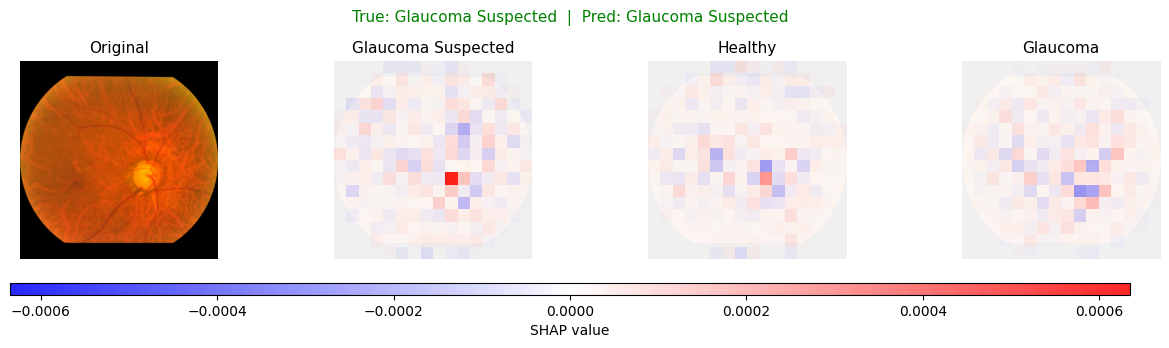

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import shap

device = config.DEVICE
num_classes = 3

FOLD_TO_USE = 1

ckpt_dir = os.path.join(config.BASE_PATH, "multi_class_checkpoints")
ckpt_path = os.path.join(ckpt_dir, f"best_model_fold_{FOLD_TO_USE}.pth")

model = get_model(config.MODEL_NAME, pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print(f"✅ Loaded model from: {ckpt_path}")

class_names = {
    0: "Glaucoma Suspected",
    1: "Healthy",
    2: "Glaucoma",
}

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

def denorm(img):
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = img.clamp(0, 1)
    img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    return img

BG_SIZE = 32

if len(main_df) < BG_SIZE:
    bg_df = main_df.sample(len(main_df), random_state=42)
else:
    bg_df = main_df.sample(BG_SIZE, random_state=42)

bg_dataset = GlaucomaDataset(bg_df.reset_index(drop=True),
                             transform=data_transforms["val"])

bg_imgs = []
for i in range(len(bg_dataset)):
    img_t, _ = bg_dataset[i]
    bg_imgs.append(img_t)

background_tensors = torch.stack(bg_imgs, dim=0).to(device)
print("Background tensor shape for SHAP:", background_tensors.shape)

explainer = shap.GradientExplainer(model, background_tensors)
print("✅ SHAP GradientExplainer initialized.")

TARGET_CLASS = 0

candidate_df = main_df[main_df["label"] == TARGET_CLASS]

if len(candidate_df) == 0:
    raise ValueError(f"No samples found for class {TARGET_CLASS} (Glaucoma Suspected).")

row = candidate_df.sample(1, random_state=None)

true_label = int(row["label"].values[0])
img_path   = row["full_path"].values[0]

test_dataset = GlaucomaDataset(row.reset_index(drop=True),
                               transform=data_transforms["val"])
x_test, y_test = test_dataset[0]
y_test = int(y_test)

x_test = x_test.unsqueeze(0).to(device)

print("🎯 Random sample (Glaucoma Suspected only):")
print("  Path:", img_path)
print("  True label:", true_label, "|", class_names.get(true_label, true_label))

with torch.no_grad():
    logits = model(x_test)
    probs = F.softmax(logits, dim=1)[0].cpu().numpy()

pred_class = int(np.argmax(probs))
pred_prob  = probs[pred_class]

print("\n🔮 Prediction probabilities:")
for c in range(num_classes):
    print(f"  P({class_names.get(c, c)}): {probs[c]:.4f}")
print(f"  → Pred: {class_names.get(pred_class, pred_class)} (class {pred_class}), p={pred_prob:.4f}")

shap_raw = explainer.shap_values(x_test)
shap_raw = np.array(shap_raw)
print("\nshap_raw.shape:", shap_raw.shape)

if shap_raw.ndim == 5 and shap_raw.shape[0] == 1:
    shap_values_all = shap_raw[0]
else:
    shap_values_all = shap_raw

print("shap_values_all.shape:", shap_values_all.shape)

img_vis = denorm(x_test)
H, W, _ = img_vis.shape

grid_size = 16
shap_maps_blocky = []
max_abs = 0.0

for c in range(num_classes):
    sv = shap_values_all[c].mean(axis=-1)

    sv_small = cv2.resize(sv, (grid_size, grid_size),
                          interpolation=cv2.INTER_AREA)
    sv_block = cv2.resize(sv_small, (W, H),
                          interpolation=cv2.INTER_NEAREST)

    shap_maps_blocky.append(sv_block)
    max_abs = max(max_abs, np.abs(sv_block).max())

if max_abs == 0:
    max_abs = 1e-7

fig, axes = plt.subplots(1, num_classes + 1,
                         figsize=(4*(num_classes+1), 3))

suptitle_color = "green" if pred_class == true_label else "red"

fig.suptitle(
    f"True: {class_names.get(true_label, true_label)}  |  "
    f"Pred: {class_names.get(pred_class, pred_class)}\n",
    color=suptitle_color,
    fontsize=11,
    y=1.05
)

axes[0].imshow(img_vis)
axes[0].axis("off")
axes[0].set_title("Original", fontsize=11)

for c in range(num_classes):
    ax = axes[c+1]

    ax.imshow(img_vis, alpha=0.35)

    im = ax.imshow(
        shap_maps_blocky[c],
        cmap="bwr",
        vmin=-max_abs,
        vmax= max_abs,
        alpha=0.85,
        interpolation="nearest"
    )
    ax.axis("off")
    ax.set_title(class_names.get(c, f"Class {c}"), fontsize=11)

plt.subplots_adjust(bottom=0.22, wspace=0.05)

cbar_ax = fig.add_axes([0.15, 0.10, 0.7, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("SHAP value")

plt.show()